# Вакансии HH.ru

**Цель проекта**: выявить различия в предлагаемых вакансиях для аналитиков данных и системных аналитиков.

**Данные**: два датасета с вакансиями для аналитиков данных и системных аналитиков.

**Презентация**: https://disk.yandex.ru/i/tusGpcdviJ-MZw

**Ход работы:**

Анализ данных начинается с предобработки, которая включает в себя рассмотрение датафреймов, поиск идентичных записей, установление столбцов с пропусками в данных. Первым этапом заполним пропуски в диапазоне заработной платы и навыках специалиста. Для устранения пропусков в навыках обработаем неявные дубликаты в них и распределим их на hard-skills и soft-skills.

Исследовательский анализ проведем в несколько этапов. Первым шагом рассмотрим, когда компании подают объявление - время суток, день недели. Затем выявим наиболее встречающийся грейд для аналитиков данных и системных аналитиков. Далее определим типичное место работы специалистов в разрезе работодателей, городов, заработной платы, типа занятости и графика работы. Каждый параметр рассмотрим в дополнительном разрезе по грейдам. Определим наиболее часто запрашиваемые soft-skills и hard-skills у кандидатов. Построим сводные таблицы по всем результатам и визуализируем их.

**Описание данных:**

`id` - уникальный идентификатор вакансии;

`name` - название вакансии;

`published_at` - дата публикации;

`alternate_url` - ссылка на вакансию;

`type` - статус вакансии на момент получения данных от api и передачи их в базу;

`employer` -рРаботодатель;

`department` - работодатель, отдел;

`area` - регион места работы;

`experience` - требуемый опыт работы;

`key_skills` - ключевые навыки, в том числе найденные при анализе полного текста вакансии. Поле генерируется после получения информации от api;

`schedule` - график работы;

`employment` - тип занятости;

`description` - описание вакансии;

`description_lemmatized` - лемматизированное описание вакансии;

`salary_from` - нижняя граница предлагаемой заработной платы;

`salary_to` - верхняя граница предлагаемой заработной платы;

`salary_bin` - категория зарплаты;

`key_skills_from_key_skills_field` - ключевые навыки из поля вакансии key_skills;

`hard_skills_from_description` - “твердые” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от api;

`soft_skills_from_description` - “мягкие” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от api.

## Предобработка данных

### Проверка на дубликаты и пропуски в данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_da = pd.read_excel('vacancies_da.xlsx') # датафрейм с аналитиками данных
df_sa = pd.read_excel('vacancies_sa.xlsx') # датафрейм с системными аналитиками

In [5]:
print(df_sa.info(), end='\n' * 2)
df_da.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1915 non-null   int64         
 1   name                              1915 non-null   object        
 2   published_at                      1915 non-null   datetime64[ns]
 3   alternate_url                     1915 non-null   object        
 4   type                              1915 non-null   object        
 5   employer                          1915 non-null   object        
 6   department                        361 non-null    object        
 7   area                              1915 non-null   object        
 8   experience                        1915 non-null   object        
 9   key_skills                        1915 non-null   object        
 10  schedule                          1915 non-null 

In [6]:
display(df_da.head())
print('\n' * 3)
df_sa.head()

id                                    name        published_at  \
0  100039284  Junior аналитик данных (исследователь) 2024-05-24 09:37:04   
1  100039480                         Аналитик данных 2024-05-24 09:39:00   
2  100042705         Аналитик данных (исследователь) 2024-05-24 10:01:25   
3  100046788                 Ведущий аналитик данных 2024-05-24 10:28:18   
4  100056244                         Аналитик данных 2024-05-24 11:27:40   

                     alternate_url      type           employer  \
0  https://hh.ru/vacancy/100039284  Открытая  DNS Головной офис   
1  https://hh.ru/vacancy/100039480  Открытая              Комус   
2  https://hh.ru/vacancy/100042705  Открытая  DNS Головной офис   
3  https://hh.ru/vacancy/100046788  Открытая           Х5 Group   
4  https://hh.ru/vacancy/100056244  Открытая             ЛУКОЙЛ   

                   department         area             experience  \
0                         NaN  Владивосток  Junior (no experince)   
1                         NaN       Москва  Junior (no experince)   
2                         NaN  Владивосток    Junior+ (1-3 years)   
3  X5 GROUP, Центральный офис       Москва    Junior+ (1-3 years)   
4                         NaN       Москва     Middle (3-6 years)   

                                          key_skills     schedule  \
0              ['Power BI', 'СУБД', 'Python', 'SQL']  Полный день   
1   ['MS SQL', 'Работа с базами данных', 'MS Excel']  Полный день   
2  ['SQL', 'Power BI', 'СУБД', 'Python', 'Clickho...  Полный день   
3  ['Анализ данных', 'Коммуникация', 'SQL', 'MS O...  Полный день   
4                                   ['Документация']  Полный день   

         employment                                        description  \
0  Полная занятость  наше направление занимается повышением эффекти...   
1  Полная занятость  сегодня комус один из крупнейших поставщиков о...   
2  Полная занятость  наше направление занимается повышением эффекти...   
3  Полная занятость  задачи:  разработка бизнес-моделей для группов...   
4  Полная занятость  обязанности:  участие в проектировании, разраб...   

                              description_lemmatized  salary_from  salary_to  \
0  наш направление заниматься повышение эффективн...      60000.0        NaN   
1  сегодня комус крупный поставщик офисный товар ...          NaN        NaN   
2  наш направление заниматься повышение эффективн...      90000.0        NaN   
3  задача разработка бизнес модель групповой прог...          NaN        NaN   
4  обязанность участие проектирование разработка ...          NaN        NaN   

      salary_bin                   key_skills_from_key_skills_field  \
0  ЗП не указана                        SQL, Power BI, Python, СУБД   
1  ЗП не указана           Работа с базами данных, MS SQL, MS Excel   
2  ЗП не указана      SQL, Power BI, Python, СУБД, BPMN, Clickhouse   
3  ЗП не указана  MS Office, SQL, Python, Hadoop, Нive, Аналитич...   
4  ЗП не указана                                                NaN   

  hard_skills_from_description soft_skills_from_description  
0                          NaN                          NaN  
1                          NaN                          NaN  
2                          NaN                          NaN  
3       Pandas, Юнит-экономика                 Коммуникация  
4                          NaN                 Документация

id                            name        published_at  \
0  100046399              Системный аналитик 2024-07-08 10:22:57   
1  100050107       Бизнес/Системный Аналитик 2024-07-06 17:19:32   
2  100059559           Системный IT аналитик 2024-07-08 11:48:17   
3  100063260  Системный Аналитик ERP-решений 2024-07-09 10:51:54   
4  100064793              Системный аналитик 2024-07-08 16:39:40   

                     alternate_url      type           employer department  \
0  https://hh.ru/vacancy/100046399  Открытая              Юрент        NaN   
1  https://hh.ru/vacancy/100050107  Открытая               Surf        NaN   
2  https://hh.ru/vacancy/100059559  Открытая           AMarkets        NaN   
3  https://hh.ru/vacancy/100063260  Открытая              Астор        NaN   
4  https://hh.ru/vacancy/100064793  Открытая  Зетта Страхование        NaN   

              area           experience  \
0           Москва   Middle (3-6 years)   
1  Санкт-Петербург  Junior+ (1-3 years)   
2           Москва  Junior+ (1-3 years)   
3           Москва    Senior (6+ years)   
4           Москва  Junior+ (1-3 years)   

                                          key_skills          schedule  \
0  ['1С', 'Аналитический склад ума', 'confluence'...       Полный день   
1  ['Разработка технических заданий', 'Бизнес-ана...  Удаленная работа   
2                                   ['Документация']       Полный день   
3  ['ERP', 'Atlassian Jira', '1С: Управление Прои...  Удаленная работа   
4  ['JSON', 'SQL', 'XML', 'SOAP', 'HTML', 'JS', '...       Полный день   

         employment                                        description  \
0  Полная занятость  юрент — это новый уровень городской мобильност...   
1  Полная занятость  в surf уже 13 лет мы разрабатываем много разны...   
2  Полная занятость  мы - международная fintech компания amarkets, ...   
3  Полная занятость  компания «астор» с 2000 года занимается разраб...   
4  Полная занятость  обязанности:   анализ задач развития и сопрово...   

                              description_lemmatized  salary_from  salary_to  \
0  юрент новый уровень городской мобильность круп...          NaN        NaN   
1  surf 13 год разрабатывать разный продукт начин...          NaN        NaN   
2  международный fintech компания amarkets 2 7 го...     233750.0        NaN   
3  компания астор 2 год заниматься разработка вне...          NaN        NaN   
4  обязанность анализ задача развитие сопровожден...          NaN        NaN   

      salary_bin                   key_skills_from_key_skills_field  \
0  ЗП не указана                   SQL, Аналитический склад ума, 1С   
1  ЗП не указана  BPMN, UML, Английский язык, Системный анализ, ...   
2  ЗП не указана                                                NaN   
3  ЗП не указана  ERP, 1С: Управление Торговлей, Atlassian Jira,...   
4  ЗП не указана      SQL, C#, Java, JS, SOAP, JSON, XML, HTML, CSS   

  hard_skills_from_description soft_skills_from_description  
0                   confluence                          NaN  
1                          NaN                 Документация  
2                          NaN                 Документация  
3                   confluence                 Коммуникация  
4                          NaN                          NaN

Датафреймы идентичны по структуре и типам данных, количество записей отличается на 104 строки.

In [7]:
print('Дубликаты записей в датафрейме аналитиков данных:', len(df_da[df_da.duplicated()]))
print('Дубликаты записей в датафрейме системных аналитиков:', len(df_sa[df_sa.duplicated()]))

Дубликаты записей в датафрейме аналитиков данных: 0
Дубликаты записей в датафрейме системных аналитиков: 0


Зафиксируем количество записей в датафреймах

In [8]:
init_shape_da = df_da.shape[0]
init_shape_sa = df_sa.shape[0]

Посчитаем количество пустых ячеек в данных

In [9]:
pass_values_da = df_da.isna().sum().sort_values(ascending=False)
pass_values_sa = df_sa.isna().sum().sort_values(ascending=False)

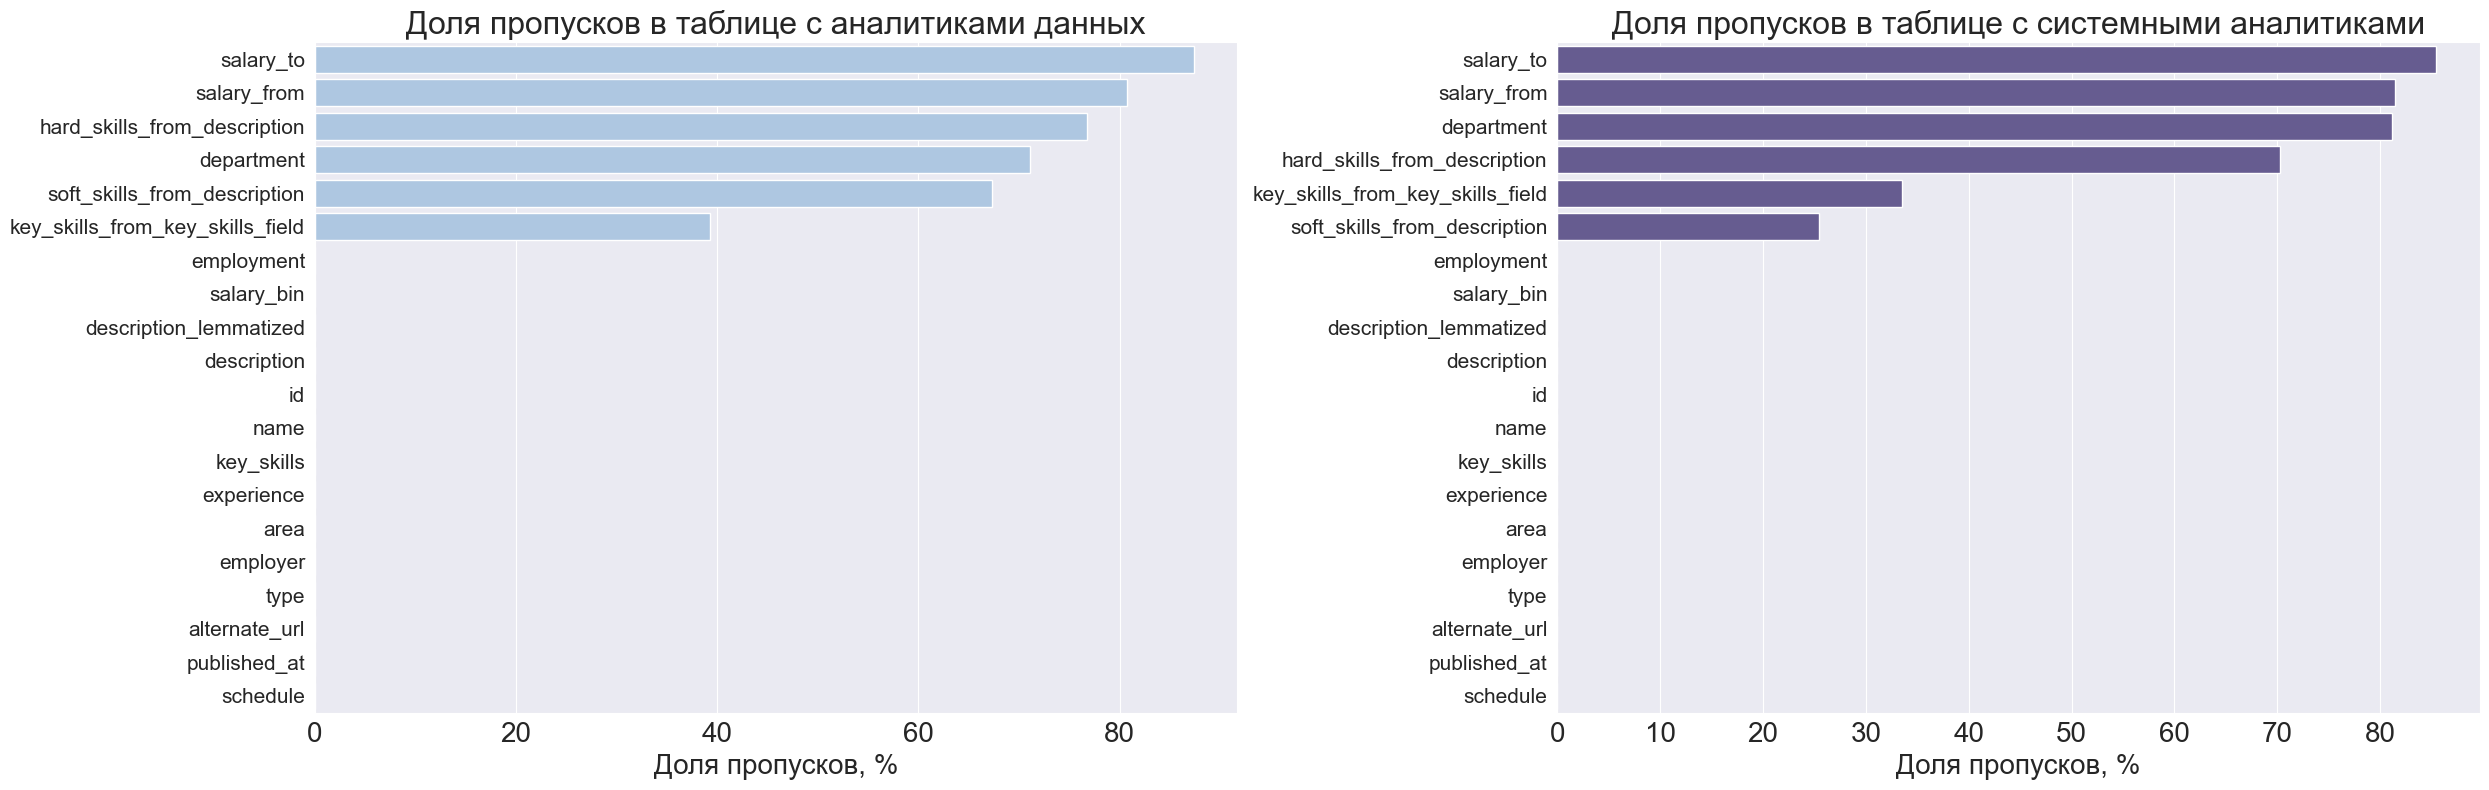

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
sns.barplot(x=pass_values_da / init_shape_da * 100, y=pass_values_da.index, color='#A5C7E9')
plt.title('Доля пропусков в таблице с аналитиками данных', fontsize=23)
plt.xlabel('Доля пропусков, %', fontsize=20)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=15)

plt.subplot(1, 2, 2)
sns.barplot(x=pass_values_sa / init_shape_sa * 100, y=pass_values_sa.index, color='#605399')
plt.title('Доля пропусков в таблице с системными аналитиками', fontsize=23)
plt.xlabel('Доля пропусков, %', fontsize=20)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=15)

plt.tight_layout()

Пропуски в двух датафреймах встречаются в одних колонках - верхняя и нижняя границы зарплаты, департамент, soft-, hard- и ключевые навыки. Наибольшее количество пропусков содержится в зарплатных границах.

### Зарплата

In [11]:
df_da['salary_bin'].value_counts()

salary_bin
ЗП не указана                1573
От 100 тысяч до 200 тысяч      96
Меньше 100 тысяч               68
От 200 тысяч до 300 тысяч      36
Больше 300 тысяч               28
Name: count, dtype: int64

Рассмотрим пропуски в колонках с зарплатой

In [12]:
def count_salary_bin(df):
    print('Количество записей с диапазоном з.п.:',
          len(df[df['salary_bin'] != 'ЗП не указана']), '\n')
    print('Количество записей, где указана нижняя граница:',
          len(df[~df['salary_from'].isna() & df['salary_to'].isna()]))
    print('Количество записей, где указана верхняя граница:',
          len(df[df['salary_from'].isna() & ~df['salary_to'].isna()]))
    print('Количество записей, где указаны обе границы:',
          len(df[~df['salary_to'].isna() & ~df['salary_from'].isna()]))

In [13]:
print('Аналитики данных')
count_salary_bin(df_da)

Аналитики данных
Количество записей с диапазоном з.п.: 228 

Количество записей, где указана нижняя граница: 194
Количество записей, где указана верхняя граница: 74
Количество записей, где указаны обе границы: 154


In [14]:
print('Системные аналитики')
count_salary_bin(df_sa)

Системные аналитики
Количество записей с диапазоном з.п.: 279 

Количество записей, где указана нижняя граница: 157
Количество записей, где указана верхняя граница: 80
Количество записей, где указаны обе границы: 199


Таким образом, можно предположить, что диапазон заработной платы выставляется исключительно для вакансий, где указана верхняя граница зарплаты или указаны обе, поскольку суммарное количество таких записей равняется количеству записей, где указан зарплатный диапазон:

**74 + 154 = 228** и **80 + 199 = 279**.

Проверим предположение. Для этого посчитаем количество вакансий аналитиков данных, где указаны обе границы или верхняя граница зарплаты, а также указано значение в итоговом диапазоне:

In [15]:
print('Количество записей составляет:',
      (len(df_da[df_da['salary_from'].isna() & ~df_da['salary_to'].isna() & (df_da['salary_bin'] != 'ЗП не указана')]) +
       len(df_da[~df_da['salary_from'].isna() & ~df_da['salary_to'].isna() & (df_da['salary_bin'] != 'ЗП не указана')])))

Количество записей составляет: 228


Предположение о выставлении диапазона зарплат подтвердилось - количество записей совпадает с числом строк, где указан диапазон.

In [16]:
df_da[~df_da['salary_from'].isna() & ~df_da['salary_to'].isna()].head(3)

id                                 name        published_at  \
12  100080002  Продуктовый аналитик / Data Analyst 2024-06-11 14:34:15   
17  100089459            Аналитик данных (в офисе) 2024-06-10 08:31:50   
26  100152009                      Аналитик данных 2024-05-25 11:09:26   

                      alternate_url      type  \
12  https://hh.ru/vacancy/100080002  Открытая   
17  https://hh.ru/vacancy/100089459  Открытая   
26  https://hh.ru/vacancy/100152009  Открытая   

                                             employer  \
12                                          Photo Lab   
17  Кадровый Центр Департамента здравоохранения го...   
26                                           Гринатом   

                                           department    area  \
12                                                NaN  Москва   
17                                                NaN  Москва   
26  Гринатом. Многофункциональный Центр Обслуживан...  Москва   

             experience                                         key_skills  \
12  Junior+ (1-3 years)  ['Linux', 'SQL', 'поведение пользователей', 'D...   
17  Junior+ (1-3 years)  ['Анализ данных', 'MS SQL', 'Python', 'Работа ...   
26  Junior+ (1-3 years)  ['Анализ данных', 'Администрирование базы данн...   

            schedule        employment  \
12  Удаленная работа  Полная занятость   
17       Полный день  Полная занятость   
26       Полный день  Полная занятость   

                                          description  \
12  making mobile photo editing available to anyon...   
17  обязанности:  написание тз на выгрузку данных ...   
26  вакансия открыта в ао &quot;атомстройэкспорт&q...   

                               description_lemmatized  salary_from  salary_to  \
12  making mobile photo editing available to anyon...     135000.0   185000.0   
17  обязанность написание тз выгрузка данные инфор...     130000.0   180000.0   
26  вакансия открывать ао quot атомстройэкспорт qu...      80000.0   100000.0   

                   salary_bin  \
12  От 100 тысяч до 200 тысяч   
17  От 100 тысяч до 200 тысяч   
26  От 100 тысяч до 200 тысяч   

                     key_skills_from_key_skills_field  \
12  SQL, PostgreSQL, Python, MS Excel, LTV, AppsFl...   
17  MS Excel, Аналитика, Анализ данных, Аналитичес...   
26  MS Excel, Анализ данных, Аналитика, Администри...   

   hard_skills_from_description soft_skills_from_description  
12                       Pandas                          NaN  
17                       Pandas                          NaN  
26                          NaN       Аналитическое мышление

В представленном выше срезе датафрейма обратим внимание на 3 строку - здесь зарплатный диапазон выставлен относительно верхней границы. Таким образом, платформа выставляет диапазон зарплаты, обращаясь только к верхнему порогу границы.

Для каждой вакансии, где указана только нижняя граница з.п., укажем, в какой зарплатный диапазон она попадает.

In [17]:
def set_salary_range(row):
    salary_from = row['salary_from']
    salary_to = row['salary_to']
    salary_bin = row['salary_bin']

    if not math.isnan(salary_from) and math.isnan(salary_to):

        if salary_from < 100_000:
            return('Меньше 100 тысяч')
        elif 100_000 <= salary_from < 200_000:
            return('От 100 тысяч до 200 тысяч')
        elif 200_000 <= salary_from < 300_000:
            return('От 200 тысяч до 300 тысяч')
        elif salary_from >= 300_000:
            return('Больше 300 тысяч')

    else:
        return(salary_bin)

In [18]:
df_da['salary_bin'] = df_da.apply(set_salary_range, axis=1)
df_sa['salary_bin'] = df_sa.apply(set_salary_range, axis=1)

In [19]:
print('Аналитики данных')
count_salary_bin(df_da)

Аналитики данных
Количество записей с диапазоном з.п.: 422 

Количество записей, где указана нижняя граница: 194
Количество записей, где указана верхняя граница: 74
Количество записей, где указаны обе границы: 154


In [20]:
print('Системные аналитики')
count_salary_bin(df_sa)

Системные аналитики
Количество записей с диапазоном з.п.: 436 

Количество записей, где указана нижняя граница: 157
Количество записей, где указана верхняя граница: 80
Количество записей, где указаны обе границы: 199


Для аналитиков данных количество пропусков в зарплатном диапазоне сократилось на 194 значения, для системных аналитиков - на 157.

### Время публикации вакансии

Для анализа даты публикации объявления, дня недели и времени выделим данные значения в новые колонки для двух датафреймов:

In [21]:
for df in [df_da, df_sa]:
    df['published_month'] = df['published_at'].dt.month
    df['published_week'] = df['published_at'].dt.weekday
    df['published_hour'] = df['published_at'].dt.hour

In [22]:
df_da[['published_at', 'published_month', 'published_week', 'published_hour']].tail()

published_at  published_month  published_week  published_hour
1796 2024-05-23 18:41:27                5               3              18
1797 2024-06-10 18:58:20                6               0              18
1798 2024-05-23 19:35:56                5               3              19
1799 2024-05-23 19:40:04                5               3              19
1800 2024-05-23 19:41:22                5               3              19

### Ключевые навыки

Для работы с ключевыми навыками приведем значения в нижний регистр:

In [23]:
df_da['key_skills'] = df_da['key_skills'].str.lower()
df_sa['key_skills'] = df_sa['key_skills'].str.lower()

Составим список уникальных навыков для двух датафреймов, затем объединим уникальные навыки в один список:

In [24]:
# функция проходится по каждой ячейке с навыками по каждому элементу списка и добавляет уникальное значение в список arr

def find_unique_skills(key_skills):
    arr = []
    for skills in key_skills:
        for skill in skills:
            if skill not in arr:
                arr.append(skill)
    return arr

Для установления навыков приведем колонку с ключевыми навыками к типу данных списков

In [25]:
df_sa['key_skills'] = df_sa['key_skills'].apply(lambda x: eval(x))
unique_skills_sa = sorted(find_unique_skills(df_sa['key_skills']))
print('Количество уникальных навыков системных аналитиков:', len(unique_skills_sa))

Количество уникальных навыков системных аналитиков: 960


In [26]:
df_da['key_skills'] = df_da['key_skills'].apply(lambda x: eval(x))
unique_skills_da = sorted(find_unique_skills(df_da['key_skills']))
print('Количество уникальных навыков аналитиков данных:',len(unique_skills_da))

Количество уникальных навыков аналитиков данных: 786


In [27]:
unique_skills = unique_skills_da + unique_skills_sa
unique_skills = sorted(list(set(unique_skills)))
count_unique_skills = len(unique_skills)
print('Общее количество уникальных навыков двух датафреймов:', len(unique_skills))

Общее количество уникальных навыков двух датафреймов: 1508


Выявим неявные дубликаты в списке с уникальными навыками и соберем все замены в словарь, где ключ - замена, значения - список неявных дубликатов

In [29]:
unique_skills[:10]

['.net',
 '.net core',
 '.net framework',
 '199-и',
 '1c',
 '1c кадры и бухгалтерия',
 '1c ух',
 '1c: erp',
 '1c: предприятие',
 '1с']

In [30]:
replacements = {
    '.net': ['.net core', '.net framework'],
    '1с-битрикс': ['bitrirx24', 'bitrix24', 'bitrix crm', 'битрикс 24', 'битрикс24', 'crm bitrix24'],
    '1с': ['1c', '1с:', '1с 8.0', '1с 8.3', 'знание 1с', 'владение прикладными решениями 1с: (1с бп, 1c ка, 1с erp)'],
    '1с: управление холдингом': ['1c ух', '1c: управление холдингом'],
    '1с: зарплата и управление персоналом': ['1с: зарплата и кадры'],
    '1с: erp': ['1с erp', '1c: erp', '1с:erp', 'erp-системы на базе 1с'],
    '1с: управление предприятием': ['1с: управление производственным предприятием', '1с: erp управление предприятием',
                                    '1с: предприятие', '1с: предприятие 8', '1c: предприятие',
                                    '1с: предприятие: управление строительной организацией'],
    '1с: управление торговлей': ['1с: торговля', '1с ут 11', '1с ут11'],
    '1с: бухгалтерия': ['1с бп'],
    '1с: предприятие: розница': ['1с: розница'],
    '1с: бит финанс': ['1с erp битфинанс'],
    'a/b тестирование': ['a/b тесты', 'a/b/n', 'ab тестирование', 'ab-test', 'abc-анализ', 'а/бх тесты','а/в-тестирования'],
    'ms access': ['access', 'microsoft access'],
    'ad-hoc': ['ad hoc analysis'],
    'agile': ['agile project management', 'agile, scrum, kanban'],
    'artificial intelligence': ['ai', 'искусственный интеллект'],
    'apache airflow': ['airflow', 'apache', 'hadoop'],
    'amplitude': ['амплитуда'],
    'anaconda': ['anaconda3'],
    'anaplan': ['анаплан'],
    'bi-аналитика': ['analytic bi', 'bi аналитик', 'bi аналитика', 'bi', 'bi инструменты', 'bi-инструменты',
                     'bi-отчетность', 'bi-система', 'business intelligence systems', 'инструменты bi', 'аналитик bi'],
    'anti-fraud': ['анти фрод', 'антифрод'],
    'appmetrica': ['appmetrika'],
    'архитектурные схемы': ['architecture analyst', 'архитектура'],
    'arenadata': ['arendata'],
    'atlassian': ['atlassian confluence', 'atlassian jira'],
    'ms dynamics ax': ['axapta'],
    'b2b': ['b2b исследования', 'b2b продажи'],
    'bss': ['base station subsystem'],
    'работа с большим объемом информации': ['bigdata', 'аналитика больших массивов данных', 'big data'],
    'bpmn': ['bpmn 2.0'],
    'bpmsoft': ['bpmnsoft', 'аналитик bpmsoft'],
    'erwin': ['bpwin'],
    'документирование бизнес-требований': ['brd'],
    'business analysis': ['бизнес анализ', 'бизнес-анализ', 'бизнес-аналитика'],
    'c4 diagram': ['c4'],
    'ci/cd': ['ci\\cd'],
    'camunda': ['comunda'],
    'confluence': ['confluence (желательно)'],
    'ms dynamics crm': ['crm dynamics'],
    'css': ['css3'],
    'создание дашбордов': ['dashboard', 'дашборд', 'построение дашбордов', 'разработка дэшбордов', 'дашборды'],
    'анализ данных': ['данных', 'data', 'data analysis', 'data analyst', 'аналитик', 'аналитик данных',
                      'аналитика', 'аналитика данных', 'исследовательский анализ данных', 'анализ', 'analysis',
                      'analyst', 'analytical skills', 'аналитические исследования', 'аналитические навыки'],
    'базы данных': ['база данных', 'базы данных', 'data base', 'знание бд', 'работа с бд', 'работа с базами данных', 'хранилища данных',
                    'хранилище данных'],
    'datalens': ['data lens', 'datalense', 'yandex data lens', 'yandex datalens'],
    'data science': ['data scientist'],
    'data warehouse': ['data warehousing'],
    'data vault': ['datavault'],
    'docker': ['doker'],
    'dwh': ['dwh lead'],
    'elasticsearch': ['elastic', 'elk'],
    'elma': ['elma 3'],
    'epc': ['epс'],
    'er-диаграммы': ['er', 'erd', 'er‑диаграммы'],
    'erp systems': ['erp'],
    'etl': ['etl framework', 'etl: informatica, loginom, плюс7 формит', 'понимание etl'],
    'ms excel': ['excel','мс excel', 'знание excel', 'ехсеl', 'работа в excel'],
    'figmа': ['figma'],
    'google analytics': ['ga4'],
    'git': ['gitlab'],
    'bigquery': ['google big query'],
    'looker studio': ['google data studio'],
    'google таблицы': ['google sheets'],
    'google tag manager': ['gtm'],
    'grafana': ['graphana'],
    'greenplum': ['greenplam', 'greenplumdb'],
    'лидерские качества': ['лидерство', 'leadership skills'],
    'html': ['html5'],
    'информационная безопасность': ['information security'],
    'jira': ['jira (желательно)'],
    'javascript': ['js'],
    'json': ['json 6', 'json api'],
    'jupyter notebook': ['jupiter'],
    'kvm': ['linux kvm'],
    'low-code': ['lowcode'],
    'машинное обучение': ['machine learning', 'mashine learning', 'ml', 'ml модели', 'ml-моделирование',
                          'ml-прогнозирование','классическое машинное обучение'],
    'математическая статистика': ['mathematical statistics'],
    'matplotlib': ['matolib'],
    'ms office': ['microsoft office', 'знание ms office', 'знание офисных программ', 'офисные программы'],
    'ms power bi': ['microsoft power bi', 'power bi', 'powerbi', 'powerbl'],
    'ms olap': ['olap', 'olap (online analytical processing)', 'olap инструменты', 'olap-кубы', 'база данных: olap'],
    'ms powerpoint': ['power point'],
    'ms sql server': ['ms sql', 'mssql'],
    'ms visio': ['visio'],
    'apache nifi': ['nifi'],
    'nosql': ['nosql субд'],
    'pandas': ['panda'],
    'php': ['php5'],
    'python': ['phyton'],
    'postgresql': ['posgresql', 'postgesql', 'postgres', 'postgresq'],
    'power query': ['powerquery'],
    'qlik sense': ['qlicksense', 'quick sense'],
    'qlikview': ['qlickview'],
    'rabbitmq': ['rabbit mq', 'rabbit.mq', 'rebbit'],
    'react': ['react.js'],
    'rest api': ['rest', 'rest ip', 'rest-api', 'restapi', 'restful api'],
    'raroc': ['rorac'],
    'soapui': ['soap ui'],
    'apache spark': ['spark'],
    'sql': ['sql запросы', 'sql-запросы', 'sql.', 'агрегатные функции'],
    'базовые знания sql': ['sql (select, join)', 'sql (простые запросы)', 'основы sql'],
    'apache superset': ['superset'],
    'swot-анализ': ['swot анализ'],
    'сиистемный анализ': ['system analysis', 'system analyst','cистемная аналитика'],
    'tcp/ip': ['tcp\\ip'],
    'transact-sql': ['t-sql'],
    'ui/ux': ['ui/ux проектирование'],
    'uml-диаграммы': ['uml', 'uml 2'],
    'use case': ['use case analysis', 'use cases', 'usecase'],
    'user story': ['user stories', 'userstory'],
    'user flow': ['ux flow'],
    'ux-схемы': ['ux модели'],
    'xsd': ['xsd-схемы'],
    'абс': ['анализ абс'],
    'бизнес-анализ': ['анализ бизнес показателей', 'анализ бизнес-процессов', 'business analysis', 'анализ и моделирование бизнес-процессов'],
    'ведение документации': ['ведение отчетности', 'ведение проектной доументации'],
    'анализ финансовых показателей': ['анализ текущих финансовых показателей'],
    'аналитический склад ума': ['аналитические способности',  'аналитическое мышление', 'математический склад ума'],
    'английский – b2': ['английский язык (upper-intermediate)'],
    'oracle db': ['база данных: oracle'],
    'брокеры сообщений': ['брокер сообщений', 'брокеры сообщений (rabbit, kafka)'],
    'бухгалтерский учет': ['бу', 'бухгалтерская отчетность'],
    'веб-аналитика': ['web аналитика'],
    'визуализация данных': ['визуализация'],
    'внимательность': ['внимание к деталям', 'внимание к деталям, скрупулезность'],
    'деловая коммуникация': ['деловая переписка', 'деловое общение'],
    'диасофт': ['диасофт 5nt'],
    'желание развиваться': ['желание обучаться', 'желание постоянно развиваться', 'желание работать и развиваться'],
    'интеграции': ['интеграция'],
    'интеграция 1с': ['интеграция учетных систем 1с'],
    'коммуникабельность': ['коммуникабельность, ответственность', 'коммуникативная гибкость', 'коммуникативные навыки',
                           'коммуникация', 'развитые коммуникативные навыки'],
    'конкурентная аналитика': ['конкурентный анализ'],
    'маркетинговая аналитика': ['маркетинговые исследования', 'маркетинговый анализ'],
    'маркетплейсы': ['маркетплейс'],
    'мобильные приложения': ['мобильное приложение'],
    'моделирование бизнес процессов': ['моделирование бизнес-процессов'],
    'написание технических заданий': ['написание тз'],
    'описание бизнес процессов': ['описание бизнес-процессов'],
    'оптимизация бизнес процессов': ['оптимизация бизнес-процессов'],
    'организаторские навыки': ['организационные навыки'],
    'отчетность': ['отчеты'],
    'пользователь пк': ['пк'],
    'продуктовый анализ': ['продуктовая аналитика'],
    'проектирование баз данных': ['проектирование бд'],
    'проектирование информационных систем': ['проектирование ис'],
    'автоматизация': ['автоматизация процессов'],
    'анализ продаж': ['аналитика продаж'],
    'витрины данных': ['витрины', 'проектирование витрин'],
    'начинающий специалист': ['мало опыта','стажер'],
    'обучение и развитие': ['обучение'],
    'продуктовый анализ': ['продуктовые метрики'],
    'проектирование архитектуры системы': ['проектирование архитектуры'],
    'clickhouse': ['сlickhouse'],
    'c#': ['с#'],
    'системная аналитика': ['сиистемный анализ', 'системный анализ', 'системный аналитик'],
    'составление технических заданий': ['составление технического задания'],
    'статистика': ['математическая статистика'],
    'субд': ['системы управления базами данных', 'система управления базами данных','cистемы управления базами данных'],
    'теория вероятностей': ['теория вероятности'],
    'техническая документация': ['техническая дркументация'],
    'техническое задание': ['тз'],
    'точность и внимательность': ['точность и внимательность к деталям'],
    'умение работать в условиях многозадачности': ['умение работа в условиям многозадачности'],
    'тайм-менеджмент': ['управление временем'],
    'функциональное тестирование': ['фт'],
    'анализ требований': ['аналитика требований'],
    'микросервисная архитектура': ['знание микросервисной архитектуры'],
    'обучаемость': ['обучение и развитие', 'способность к саморазвитию'],
    'опытный пользователь пк': ['продвинутый пользователь пк', 'уверенный пользователь пк (ms office)'],
    'ответственность': ['ответственный подход к работе'],
    'регрессионный анализ': ['понимание задач регрессии'],
    'продуктовая аналитика': ['продуктовый анализ'],
    'работа в режиме многозадачности': ['работа в условиях многозадачности'],
    'разработка проектной документации': ['разработка проектных документов'],
    'системное мышление': ['системность мышления','‒ системное мышление'],
}

In [31]:
# получаем список уникалных значений
for key, values in replacements.items():
    for value in values:
        unique_skills = [key if el == value else el for el in unique_skills]
unique_skills = sorted(list(set(unique_skills)))
unique_skills[:10]

['.net',
 '199-и',
 '1c кадры и бухгалтерия',
 '1с',
 '1с программирование',
 '1с-битрикс',
 '1с: erp',
 '1с: бит финанс',
 '1с: бухгалтерия',
 '1с: бухгалтерия и склад']

In [32]:
print('Количество уникальных навыков после удаления неявных дубликатов:', len(unique_skills))
print(f'Количество уникальных навыков сократилось на {round((count_unique_skills - len(unique_skills)) / count_unique_skills * 100, 2)}%')

Количество уникальных навыков после удаления неявных дубликатов: 1187
Количество уникальных навыков сократилось на 21.29%


Используем словарь замен для двух датафреймов

In [31]:
# Функция проверяет встречаемость неявных дубликатов
def detect_implicit_dupl(row):
    key_skills = row['key_skills']

    for key, values in replacements.items():
        for value in values:
            key_skills = [key if el == value else el for el in key_skills]
    return(key_skills)

In [32]:
df_da['key_skills'] = df_da.apply(detect_implicit_dupl, axis=1)
df_sa['key_skills'] = df_sa.apply(detect_implicit_dupl, axis=1)

Для заполнения пустых ячеек в колонках с soft и hard навыками распределим ключевые навыки на две категории. Для этого вручную обработаем меньший из списков - soft-навыки, а hard-навыки составим из оставшихся элементов ключевых навыков.

In [34]:
soft_skills = ['адаптивность','амбициозность','аналитический склад ума','ведение переговоров','ведение переписки','взаимодействие с заказчиком',
               'внимательность','внимательность к деталям, умение работать с большими объемами информации','высокий уровень самоорганизации',
               'генерация идей','гибкость мышления','готовность обучаться','грамотная речь','грамотная речь и письмо','грамотность',
               'деловая коммуникация','доброжелательность','добросовестность','дружелюбие','желание зарабатывать','желание развиваться',
               'заключение договоров','инициативность в решении задач','инициативность и лидерство','исполнение поручений руководителя',
               'исходящие звонки','клиентоориентированность','коммуникабельность','консультирование','консультирование клиентов',
               'консультирование клиентов по телефону','корпоративная этика','креативность','критическое мышление','лидерские качества','логика',
               'логическое мышление','многозадачность','мотивированность','навыки межличностного общения','навыки переговоров','навыки презентации',
               'навыки продаж','наставничество','начинающий специалист','обучаемость','общение с заказчиком','организаторские навыки',
               'организация деловых поездок','организация мероприятий','организация переговоров с представителями государственных органов',
               'организация совещаний','организация учебного процесса','ориентация на клиента','ориентация на результат','ответственность',
               'ответственность и пунктуальность','ответственность, внимательность','переговоры','письменная коммуникация','планирование',
               'планирование и организация','подготовка презентаций','презентация результатов','преподаватель','принятие решений','проактивность',
               'проведение опросов','проведение презентаций','проведение телефонных интервью','проектный менеджмент','проработка тз',
               'противодействие мошенничеству','работа в команде','работа в режиме многозадачности','работа со сми','ревью тест-кейсов',
               'решение проблем','руководитель проекта','руководство коллективом','руководство командой','руководство командой разработчиков',
               'русский язык','сбор и анализ бизнес-требований от заказчика','системное мышление','системность','системный подход',
               'способность к систематизации','способность эффективно решать проблемы','стратегическое мышление','стрессоустойчивость','тайм-менеджмент',
               'телекоммуникации','точность и внимательность','удаленная работа','умение анализировать','умение анализировать информацию',
               'умение легко находить контакт с людьми','умение принимать решения','умение работать в коллективе','умение работать в команде',
               'умение работать в условиях многозадачности','управление командой','управление ожиданиями','управление персоналом',
               'управленческие навыки','усидчивость','целеустремленность','эмпатия','‒ активная позиция','‒ интерес и широкий кругозор',
               '• деловая коммуникация • общение с клиентами • работа в условиях многозадачности • опыт работы в ком', 'постановка задач разработчикам',
               'документация']

In [35]:
# находим hard навыки
hard_skills = []
for skill in unique_skills:
    if skill not in soft_skills:
         hard_skills.append(skill)
        
hard_skills[:10]

['.net',
 '199-и',
 '1c кадры и бухгалтерия',
 '1с',
 '1с программирование',
 '1с-битрикс',
 '1с: erp',
 '1с: бит финанс',
 '1с: бухгалтерия',
 '1с: бухгалтерия и склад']

In [35]:
# переводим данные навыков в нижний регистр, все навыки помещаем в списки, заполняем пустые ячейки пустой строкой
skills_from_description = ['hard_skills_from_description', 'soft_skills_from_description']
dfs = [df_da, df_sa]

for df in dfs:
    for col in skills_from_description:
        df[col] = df[col].str.lower().str.split(', ').fillna('')

In [36]:
# функция для заполнения hard-навыков. Использует список hard_skills
def create_hard_skills(row):
    hard = row['hard_skills_from_description']
    key_skills = row['key_skills']

    if hard == '':
        arr = []
        for skill in key_skills:
            if skill in hard_skills:
                arr.append(skill)
        return arr
    else:
        return hard

In [37]:
df_da['hard_skills_from_description'] = df_da.apply(create_hard_skills, axis=1)
df_sa['hard_skills_from_description'] = df_sa.apply(create_hard_skills, axis=1)

In [38]:
# функция для заполнения soft-навыков. Использует список soft_skills
def create_soft_skills(row):
    soft = row['soft_skills_from_description']
    key_skills = row['key_skills']

    if soft == '':
        arr = []
        for skill in key_skills:
            if skill in soft_skills:
                arr.append(skill)
        return arr
    else:
        return soft

In [39]:
df_da['soft_skills_from_description'] = df_da.apply(create_soft_skills, axis=1)
df_sa['soft_skills_from_description'] = df_sa.apply(create_soft_skills, axis=1)

Итоговый вариант предобработки ключевых навыков

In [40]:
print('Аналитики данных')
display(df_da[['key_skills', 'hard_skills_from_description', 'soft_skills_from_description']].tail(7))
print('\n' * 2, 'Системные аналитики')
df_sa[['key_skills', 'hard_skills_from_description', 'soft_skills_from_description']].tail(7)

Аналитики данных


key_skills  \
1794  [внутренний контроль, внутренний аудит информа...   
1795  [проактивность, коммуникабельность, sql, ad-ho...   
1796  [проактивность, коммуникабельность, sql, ad-ho...   
1797  [грамотная речь, сводные таблицы, сбор и анали...   
1798  [анализ данных, sql, ms power bi, python, анал...   
1799  [анализ данных, sql, ms power bi, python, анал...   
1800  [анализ данных, sql, ms power bi, python, анал...   

                           hard_skills_from_description  \
1794  [внутренний контроль, внутренний аудит информа...   
1795  [sql, ad-hoc, a/b тестирование, python, ltv, e...   
1796  [sql, ad-hoc, a/b тестирование, python, ltv, e...   
1797  [сводные таблицы, сбор и анализ информации, ан...   
1798  [анализ данных, sql, ms power bi, python, анал...   
1799  [анализ данных, sql, ms power bi, python, анал...   
1800  [анализ данных, sql, ms power bi, python, анал...   

                           soft_skills_from_description  
1794                          [аналитический склад ума]  
1795                      [коммуникация, проактивность]  
1796                      [коммуникация, проактивность]  
1797  [грамотная речь, аналитический склад ума, дело...  
1798                                                 []  
1799                                                 []  
1800                                                 []



 Системные аналитики


key_skills  \
1908  [разработка технических заданий, постановка за...   
1909  [разработка технических заданий, ms sql server...   
1910                 [документация, коммуникабельность]   
1911  [idef, разработка технических заданий, rest ap...   
1912                                                 []   
1913  [soa, xml, atlassian, use case, db2, bpmn, api...   
1914  [документация, 1с: управление предприятием, 1с...   

                           hard_skills_from_description  \
1908  [разработка технических заданий, sql, анализ д...   
1909  [разработка технических заданий, ms sql server...   
1910                                                 []   
1911  [idef, разработка технических заданий, rest ap...   
1912                                                 []   
1913                                       [confluence]   
1914  [1с: управление предприятием, 1с: бит финанс, ...   

                           soft_skills_from_description  
1908                                     [документация]  
1909  [аналитический склад ума, аналитический склад ...  
1910                       [коммуникация, документация]  
1911                                     [документация]  
1912                                                 []  
1913                                                 []  
1914                                     [документация]

Некоторые ячейки содержат не все hard- и soft- навыки, которые представлены в списках key_skills, такие ячейки изначально были заполнены работодателем, поэтому созданные выше функции для заполнения hard- и soft- навыков не были к ним применимы.

### Вывод
В ходе предобработки данных были рассмотрены два датафрейма с вакансиями для аналитиков данных и системных аналитиков. Были установлены колонки, содержащие пропуски - диапазоны зарплат, департамент и навыки специалиста.
1. Зарплата. Было установлено, что зарплатный диапазон выставляется ссылаясь на верхнюю границы зарплаты. Пропуски диапазона заработной платы были заполнены для записей, где представлена только нижняя граница.
2. Время публикации вакансии. Были выделены три новых столбца для двух датафреймов, содержащие месяц публикации объявления, день недели и время.
3. Ключевые навыки. Проведена работа над выявлением неявных дубликатов колонки с ключевыми навыками. Все установленные уникальные навыки были распределены по двум спискам - soft- и hard-skills. Таким образом, были устранены все пропуски в soft- и hard-навыках.

## Функции для построения таблиц и графиков для исследовательской части проекта

Данный раздел содержит функции для построения сводных таблиц и дальнейших визуализаций. Все функции за исключением последний представлены в связке - визуализации не будут работать без предварительного построения сводных таблиц. Такой подход позволяет отображать данные как графически, так и в табличном виде для удобства работы.

Построение сводной таблицы для аналитиков данных и системных аналитиков для установления типичного места работы

In [41]:
def set_typical_job(df_1, df_2, feature, column_name, main_columns_name):
    dfs = [df_1, df_2]
    result = []

    for df in dfs:
        df = df[feature].value_counts().reset_index()[:10]
        result.append(df)

    result = pd.concat(result, axis=1).T

    multi_index = pd.DataFrame(
        [["Аналитики данных", column_name], ["Аналитики данных", 'Количество вакансий'],
         ["Системные аналитики", column_name], ["Системные аналитики", 'Количество вакансий']],
        columns=["Должность", main_columns_name])

    multi_index = pd.MultiIndex.from_frame(multi_index)

    result.set_index(multi_index, inplace=True)
    result = result.T

    return result

Построение графиков для аналитиков данных и системных аналитиков для установления типичного места работы с использованием данных предыдущей таблицы


In [42]:
def plot_typical_job(df, feature):
    positions = ['Аналитики данных', 'Системные аналитики']
    color = ['#A5C7E9', '#605399']
    bar_label_color = ['black', 'white']
    plt.figure(figsize=(25, 8))


    for i, position in enumerate(positions):
            ax = plt.subplot(1, 2, i + 1)
            ax = df[position].sort_values(by='Количество вакансий').plot(kind='barh', x=feature, legend=False, ax=ax, color=color[i], width=0.8)
            plt.title(position, fontsize=30)
            plt.xlabel('Количество вакансий', fontsize=20)
            plt.ylabel('', fontsize=1)
            plt.tick_params(axis='x', labelsize=20)
            plt.tick_params(axis='y', labelsize=20)
            ax.bar_label(ax.containers[0], fontsize=20, label_type='center', color=bar_label_color[i])

    plt.tight_layout()
    plt.show()

----

Функция для построения сводной таблицы для установления типичного места работы в разрезе грейдов

In [43]:
def build_pivot_table(df, feature, column_name, main_columns_name):
    result = []
    experience = ["Junior (no experince)", "Junior+ (1-3 years)", "Middle (3-6 years)", "Senior (6+ years)"]

    for rank in experience:
        experience_df = df[df['experience'] == rank]
        experience_df = experience_df[feature].value_counts().reset_index()[:5]
        result.append(experience_df)

    result = pd.concat(result, axis=1).T

    multi_index = pd.DataFrame(
        [["Junior", column_name], ["Junior", 'Количество вакансий'],
         ["Junior +", column_name], ["Junior +", 'Количество вакансий'],
         ["Middle", column_name], ["Middle", 'Количество вакансий'],
         ["Senior", column_name], ["Senior", 'Количество вакансий']],
        columns=["Грейд", main_columns_name])

    multi_index = pd.MultiIndex.from_frame(multi_index)

    result.set_index(multi_index, inplace=True)
    result = result.T

    return(result)

Функция для построения графиков для установления типичного места работы в разрезе грейдов

In [44]:
def plot_pivot_table(df_1, df_2, feature):
    plot_titles = ['Аналитики данных', 'Системные аналитики']
    experience = ["Junior", "Junior +", "Middle", "Senior"]
    color=['#76b8ea', '#cfaee7', '#4e9cda', '#b480d3', '#357abb', '#9954c4', '#2d649d', '#77379F']
    plt.figure(figsize=(30, 25))
    dfs = [df_1, df_2]

    for i, rank in enumerate(experience):
        for j, df in enumerate(dfs):
            ax = plt.subplot(4, 2, i * 2 + j + 1)
            ax = (df[rank].sort_values(by='Количество вакансий').plot(kind='barh', x=feature, legend=False, ax=ax, color=color[(i * 2 + j)]))
            plt.title(rank, fontsize=33)
            plt.ylabel('', fontsize=1)
            plt.tick_params(axis='x', labelsize=25)
            plt.tick_params(axis='y', labelsize=30)
            ax.bar_label(ax.containers[0], fontsize=30, label_type='center', color='white')

    for idx, title in enumerate(plot_titles):
        plt.figtext(0.25 + idx * 0.5, 1.01, title, fontsize=37)

    plt.tight_layout()
    plt.show()

----

Функция для построения сводной таблицы для key_skills, soft- и hard-навыков

In [45]:
def set_top_skills(df):
    skills = ['key_skills', 'hard_skills_from_description', 'soft_skills_from_description']
    result = []

    for skill in skills:
        new_df = df[skill].explode().value_counts().reset_index()[:10]
        result.append(new_df)

    result = pd.concat(result, axis=1).T

    multi_index = pd.DataFrame(
        [["Key skills", 'Навыки'], ["Key skills", 'Количество вакансий с навыком'],
         ["Hard skills", 'Навыки'], ["Hard skills", 'Количество вакансий с навыком'],
         ["Soft skills", 'Навыки'], ["Soft skills", 'Количество вакансий с навыком']],
        columns=["Тип навыка", 'Встречаемость'])

    multi_index = pd.MultiIndex.from_frame(multi_index)

    result.set_index(multi_index, inplace=True)
    result = result.T

    return result

Функция для построения графиков для key_skills, soft- и hard-навыков

In [46]:
def plot_skills(df_1, df_2):
    skills = ["Key skills", "Hard skills", "Soft skills"]
    plot_titles = ['Аналитики данных', 'Системные аналитики']
    dfs = [df_1, df_2]
    color = ['#a5509f', '#d66eab', '#72c9b8', '#aed688','#f69173','#fcb247']
    plt.figure(figsize=(30,25))

    for i, skill in enumerate(skills):
        for j, df in enumerate(dfs):
            ax = plt.subplot(3, 2, i * 2 + j + 1)
            ax = (df[skill].sort_values(by='Количество вакансий с навыком').plot(kind='barh', x='Навыки',
                                                                                 legend=False, ax=ax, width=0.8,
                                                                                 color=color[i * 2 + j]))
            plt.title(skill, fontsize=33)
            plt.ylabel('', fontsize=1)
            plt.tick_params(axis='x', labelsize=25)
            plt.tick_params(axis='y', labelsize=30)
            ax.bar_label(ax.containers[0], fontsize=30, label_type='center', color='white')

    for idx, title in enumerate(plot_titles):
        plt.figtext(0.25 + idx * 0.5, 1.01, title, fontsize=37)

    plt.tight_layout()
    plt.show()

___

Функция для построения сводной таблицы для навыков в разрезе грейдов. Для визуализации подходит представленная выше функция - plot_pivot_table.

In [47]:
def set_top_skills_experience(df, type_of_skill):
    result = []
    experience = ["Junior (no experince)", "Junior+ (1-3 years)", "Middle (3-6 years)", "Senior (6+ years)"]

    for rank in experience:
        experience_df = df[df['experience'] == rank]
        experience_skill_df = experience_df[type_of_skill].explode().value_counts().reset_index()[:5]
        result.append(experience_skill_df)

    result = pd.concat(result, axis=1).T

    multi_index = pd.DataFrame(
        [['Junior', 'Аналитик данных'], ['Junior', 'Количество вакансий'],
         ["Junior +", 'Аналитик данных'], ["Junior +", 'Количество вакансий'],
         ["Middle", 'Аналитик данных'], ["Middle", 'Количество вакансий'],
         ["Senior", 'Аналитик данных'], ["Senior", 'Количество вакансий']],

        columns=["Грейд", 'Должность'])

    multi_index = pd.MultiIndex.from_frame(multi_index)

    result.set_index(multi_index, inplace=True)
    result = result.T

    return(result)

________

Функция для заполнения пустых ячеек для сводных таблиц

In [48]:
def del_nan(df, feature):
    ranks = ["Junior", "Junior +", "Middle", "Senior"]
    for rank in ranks:
        df[rank, 'Количество вакансий'] = df[rank, 'Количество вакансий'].fillna(0)
        df[rank, feature] = df[rank, feature].fillna('Вакансии отсутствуют')
    return(df)

## Исследовательский анализ данных

### Момент публикации объявлений

In [49]:
print('Аналитики данных', df_da['published_at'].min(), df_sa['published_at'].max(), sep='\n')

Аналитики данных
2024-02-13 21:45:51
2024-07-09 12:47:11


In [50]:
print('Системные аналитики', df_sa['published_at'].min(), df_sa['published_at'].max(), sep='\n')

Системные аналитики
2024-06-27 06:08:10
2024-07-09 12:47:11


Сравнивать данные в рамках одной временной шкалы в нашем случае не получится, поскольку сбор вакансий происходил в разных временных диапазонах - для аналитиков данных - февраль-июль, для системных аналитиков - июнь, июль.

In [51]:
def plot_published_week(df_1, df_2, title_1, title_2):
    color = ['#A5C7E9', '#605399']
    title = [title_1, title_2]

    plt.figure(figsize=(12, 4))
    for i, df in enumerate([df_1, df_2]):
        plt.subplot(1, 2, i + 1)
        df['published_week'].value_counts().plot(kind='bar', width=0.75, color=color[i])
        labels_x = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']
        plt.xticks(range(7), labels_x, rotation=0)
        plt.xlabel('День недели')
        plt.title(title[i])

    plt.figtext(0.33, 1, 'Распределение публикации объявлений по дням недели', fontsize=12)

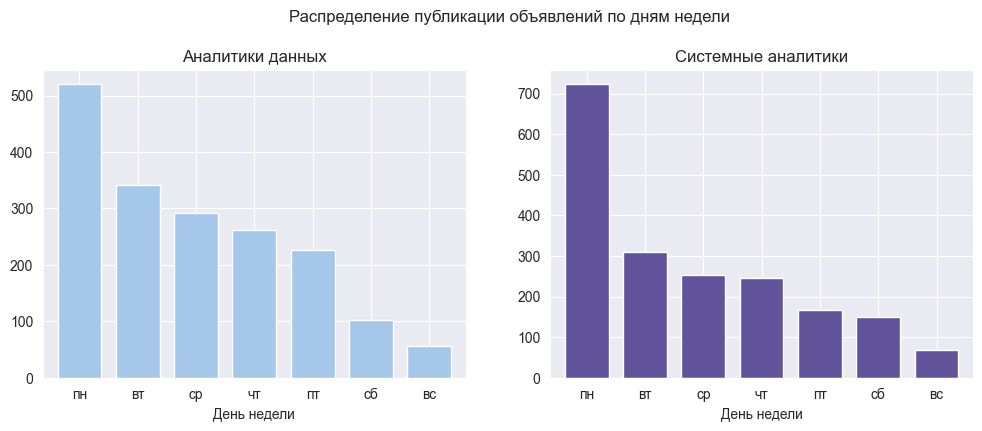

In [52]:
plot_published_week(df_da, df_sa, 'Аналитики данных', 'Системные аналитики')

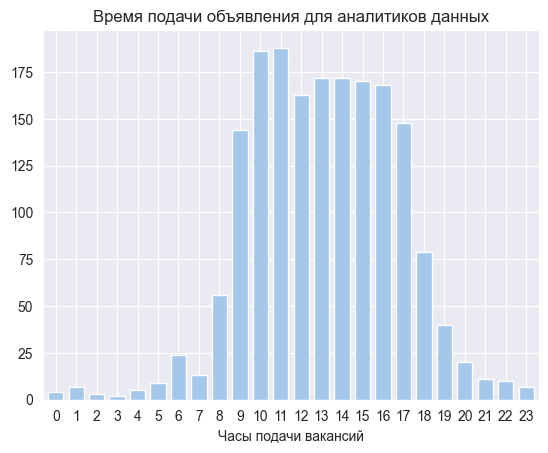

In [53]:
(df_da['published_hour'].value_counts().reset_index().sort_values(by='published_hour')
                        .plot(x='published_hour', kind='bar', width=0.75, color='#A5C7E9', legend=False))
plt.xticks(rotation=0)
plt.xlabel('Часы подачи вакансий')
plt.title('Время подачи объявления для аналитиков данных');

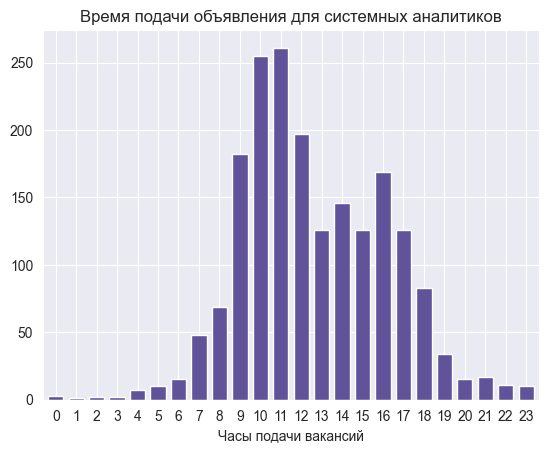

In [54]:
(df_sa['published_hour'].value_counts().reset_index().sort_values(by='published_hour')
                        .plot(x='published_hour', kind='bar', width=0.75, color='#605399', legend=False))
plt.xticks(rotation=0)
plt.xlabel('Часы подачи вакансий')
plt.title('Время подачи объявления для системных аналитиков');

Большинство объявлений выкладывается по понедельникам, затем количество публикуемых вакансий снижается с каждым днем и минимальное количество, как правило, выкладывается в выходные.

Большинство вакансий выкладывается в рабочие часы с 8 утра до 8 вечера. Пик подачи достигается утром с 9 до 12 часов.

### Грейд кандидатов

In [55]:
experience_da = df_da['experience'].value_counts().reset_index()
experience_da['доля среди всех аналитиков данных, %'] = round((experience_da['count'] / init_shape_da) * 100, 1)

experience_sa = df_sa['experience'].value_counts().reset_index()
experience_sa['доля среди всех системных аналитиков, %'] = round((experience_sa['count'] / init_shape_sa) * 100, 1)

experience = experience_da.merge(experience_sa, how='left', on='experience')
experience = (experience.rename(columns={'experience': 'грейд', 'count_x': 'аналитики данных', 'count_y': 'системные аналитики'})
                        .sort_values(by='грейд'))
experience

грейд  аналитики данных  \
2  Junior (no experince)               142   
0    Junior+ (1-3 years)              1091   
1     Middle (3-6 years)               555   
3      Senior (6+ years)                13   

   доля среди всех аналитиков данных, %  системные аналитики  \
2                                   7.9                   86   
0                                  60.6                  852   
1                                  30.8                  933   
3                                   0.7                   44   

   доля среди всех системных аналитиков, %  
2                                      4.5  
0                                     44.5  
1                                     48.7  
3                                      2.3

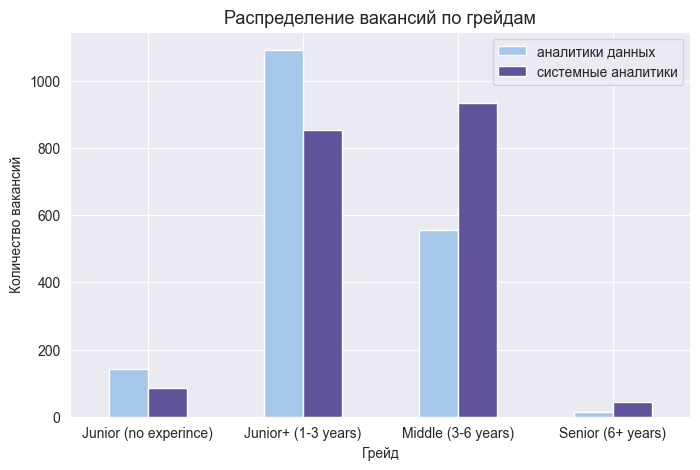

In [56]:
sns.set_style('darkgrid')
experience[['грейд', 'аналитики данных', 'системные аналитики']].plot(x='грейд', kind='bar', figsize=(8, 5),
                                                                      color=['#A5C7E9', '#605399'])
plt.title('Распределение вакансий по грейдам', fontsize=13)
plt.xlabel('Грейд')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=0);

Наибольшее количество представленных вакансий размещены для грейдов Junior+ и Middle.

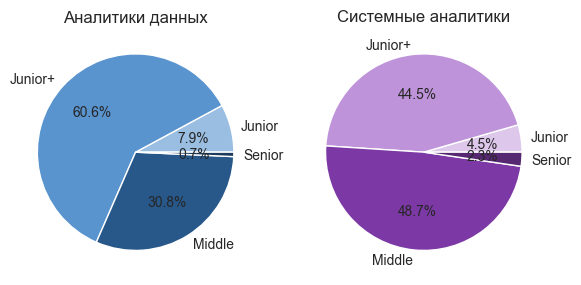

In [57]:
plt.figure(figsize=(6, 4))

sns.set_palette(['#9ABEE2', '#5994CF', '#275889', '#1A3B5C'])
ax = plt.subplot(1, 2, 1)
plt.pie(experience['аналитики данных'], labels=['Junior', 'Junior+', 'Middle', 'Senior'], autopct='%.1f%%', textprops={'fontsize': 10})
plt.title('Аналитики данных', fontsize=12)

sns.set_palette(['#DDC7EB', '#BE93D9', '#7C39A5', '#562872'])
ax = plt.subplot(1, 2, 2)
plt.pie(experience['системные аналитики'], labels=['Junior', 'Junior+', 'Middle', 'Senior'], autopct='%.1f%%', textprops={'fontsize': 10})
plt.title('Системные аналитики', fontsize=12)
plt.tight_layout();

Как видно из диаграммы, для аналитиков данных больше половины вакансий предполагают грейд Junior+ - 60,6%, менее востребованы специалисты Middle - 30,8%, вакансии Junior составляют 7,9% и наименьшая доля относится к самому высокому грейду - Senior - менее процента.
Распределение грейдов системных аналитиков отличается - практически с одинаковой долей встречаются вакансии с грейдом Middle - 48,7% и Junior+ - 44,5%, и наименьшее количество объявлений для грейдов Junior - 4,5% и Senior - 2,3%.

### Типичное место работы

#### Работодатели

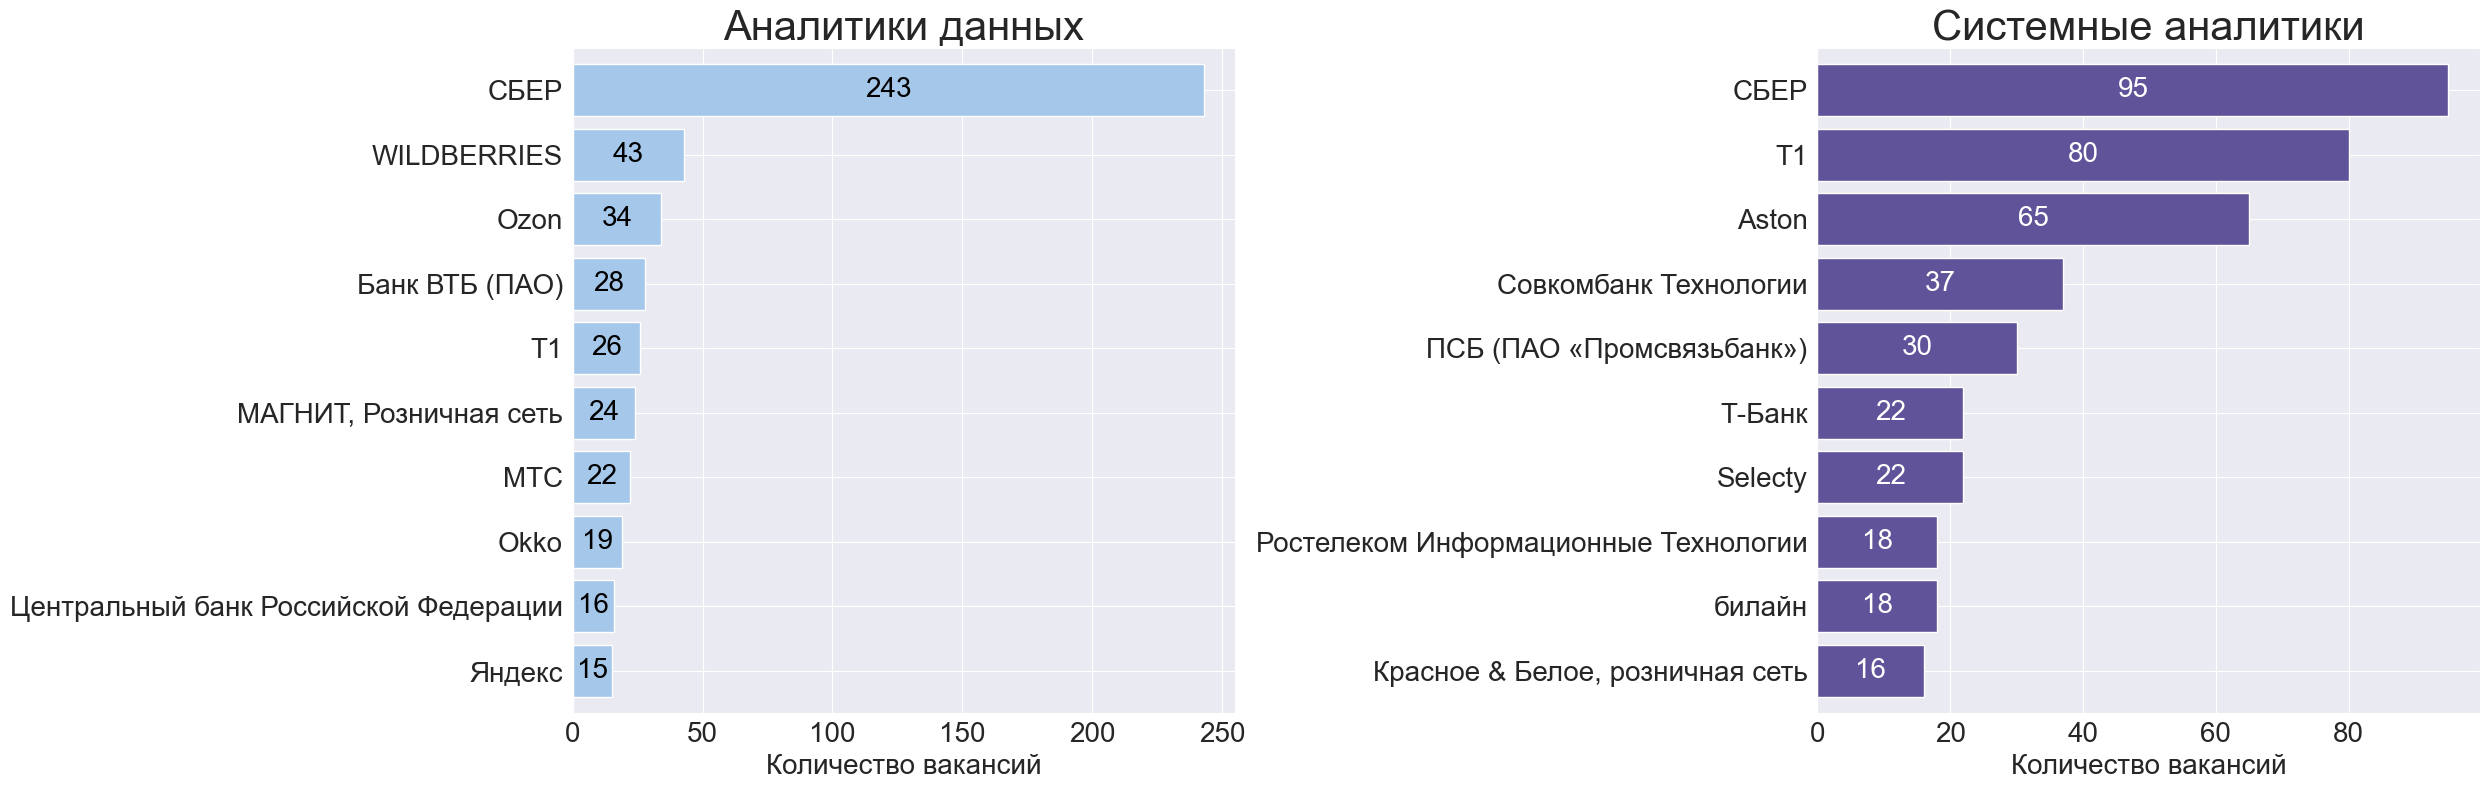

In [58]:
employer_df = set_typical_job(df_da, df_sa, 'employer', 'Работодатель', 'Топ-работодателей')
plot_typical_job(employer_df, 'Работодатель')

Наибольшее количество вакансий для обеих должностей представлено компанией "СБЕР", особенно выделяется количество вакансий для аналитиков данных - 243. Для аналитиков данных уже второе место в топе отличается более чем в пять раз по количеству представленных вакансий на сайте - WILDBERRIES, 43 объявления, затем идет плавное снижение до 10 позиции в рейтинге по количеству вакансий - компания "Яндекс" с общим числом объявлений - 15. Вакансии системных аналитиков имеют более линейный спад количества объявлений, после компании "СБЕР" следуют "T1" и "Aston", с общим числом объявлений 80 и 65 соответственно.

#### Работодатели в разрезе грейдов

In [59]:
employer_da = build_pivot_table(df_da, 'employer', 'Работодатели', 'Топ-работодателей')
employer_sa = build_pivot_table(df_sa, 'employer', 'Работодатели', 'Топ-работодателей')

employer_sa['Junior'] = employer_sa['Junior'].replace('Компания Апогей (1С-франчайзи)', 'Компания Апогей')
employer_sa['Junior +'] = employer_sa['Junior +'].replace('Красное & Белое, розничная сеть', 'Красное & Белое')
employer_sa['Middle'] = employer_sa['Middle'].replace('ПСБ (ПАО «Промсвязьбанк»)', 'ПСБ')
employer_sa['Senior'] = employer_sa['Senior'].replace('БФТ-Холдинг (Бюджетные и Финансовые Технологии)', 'БФТ-Холдинг')

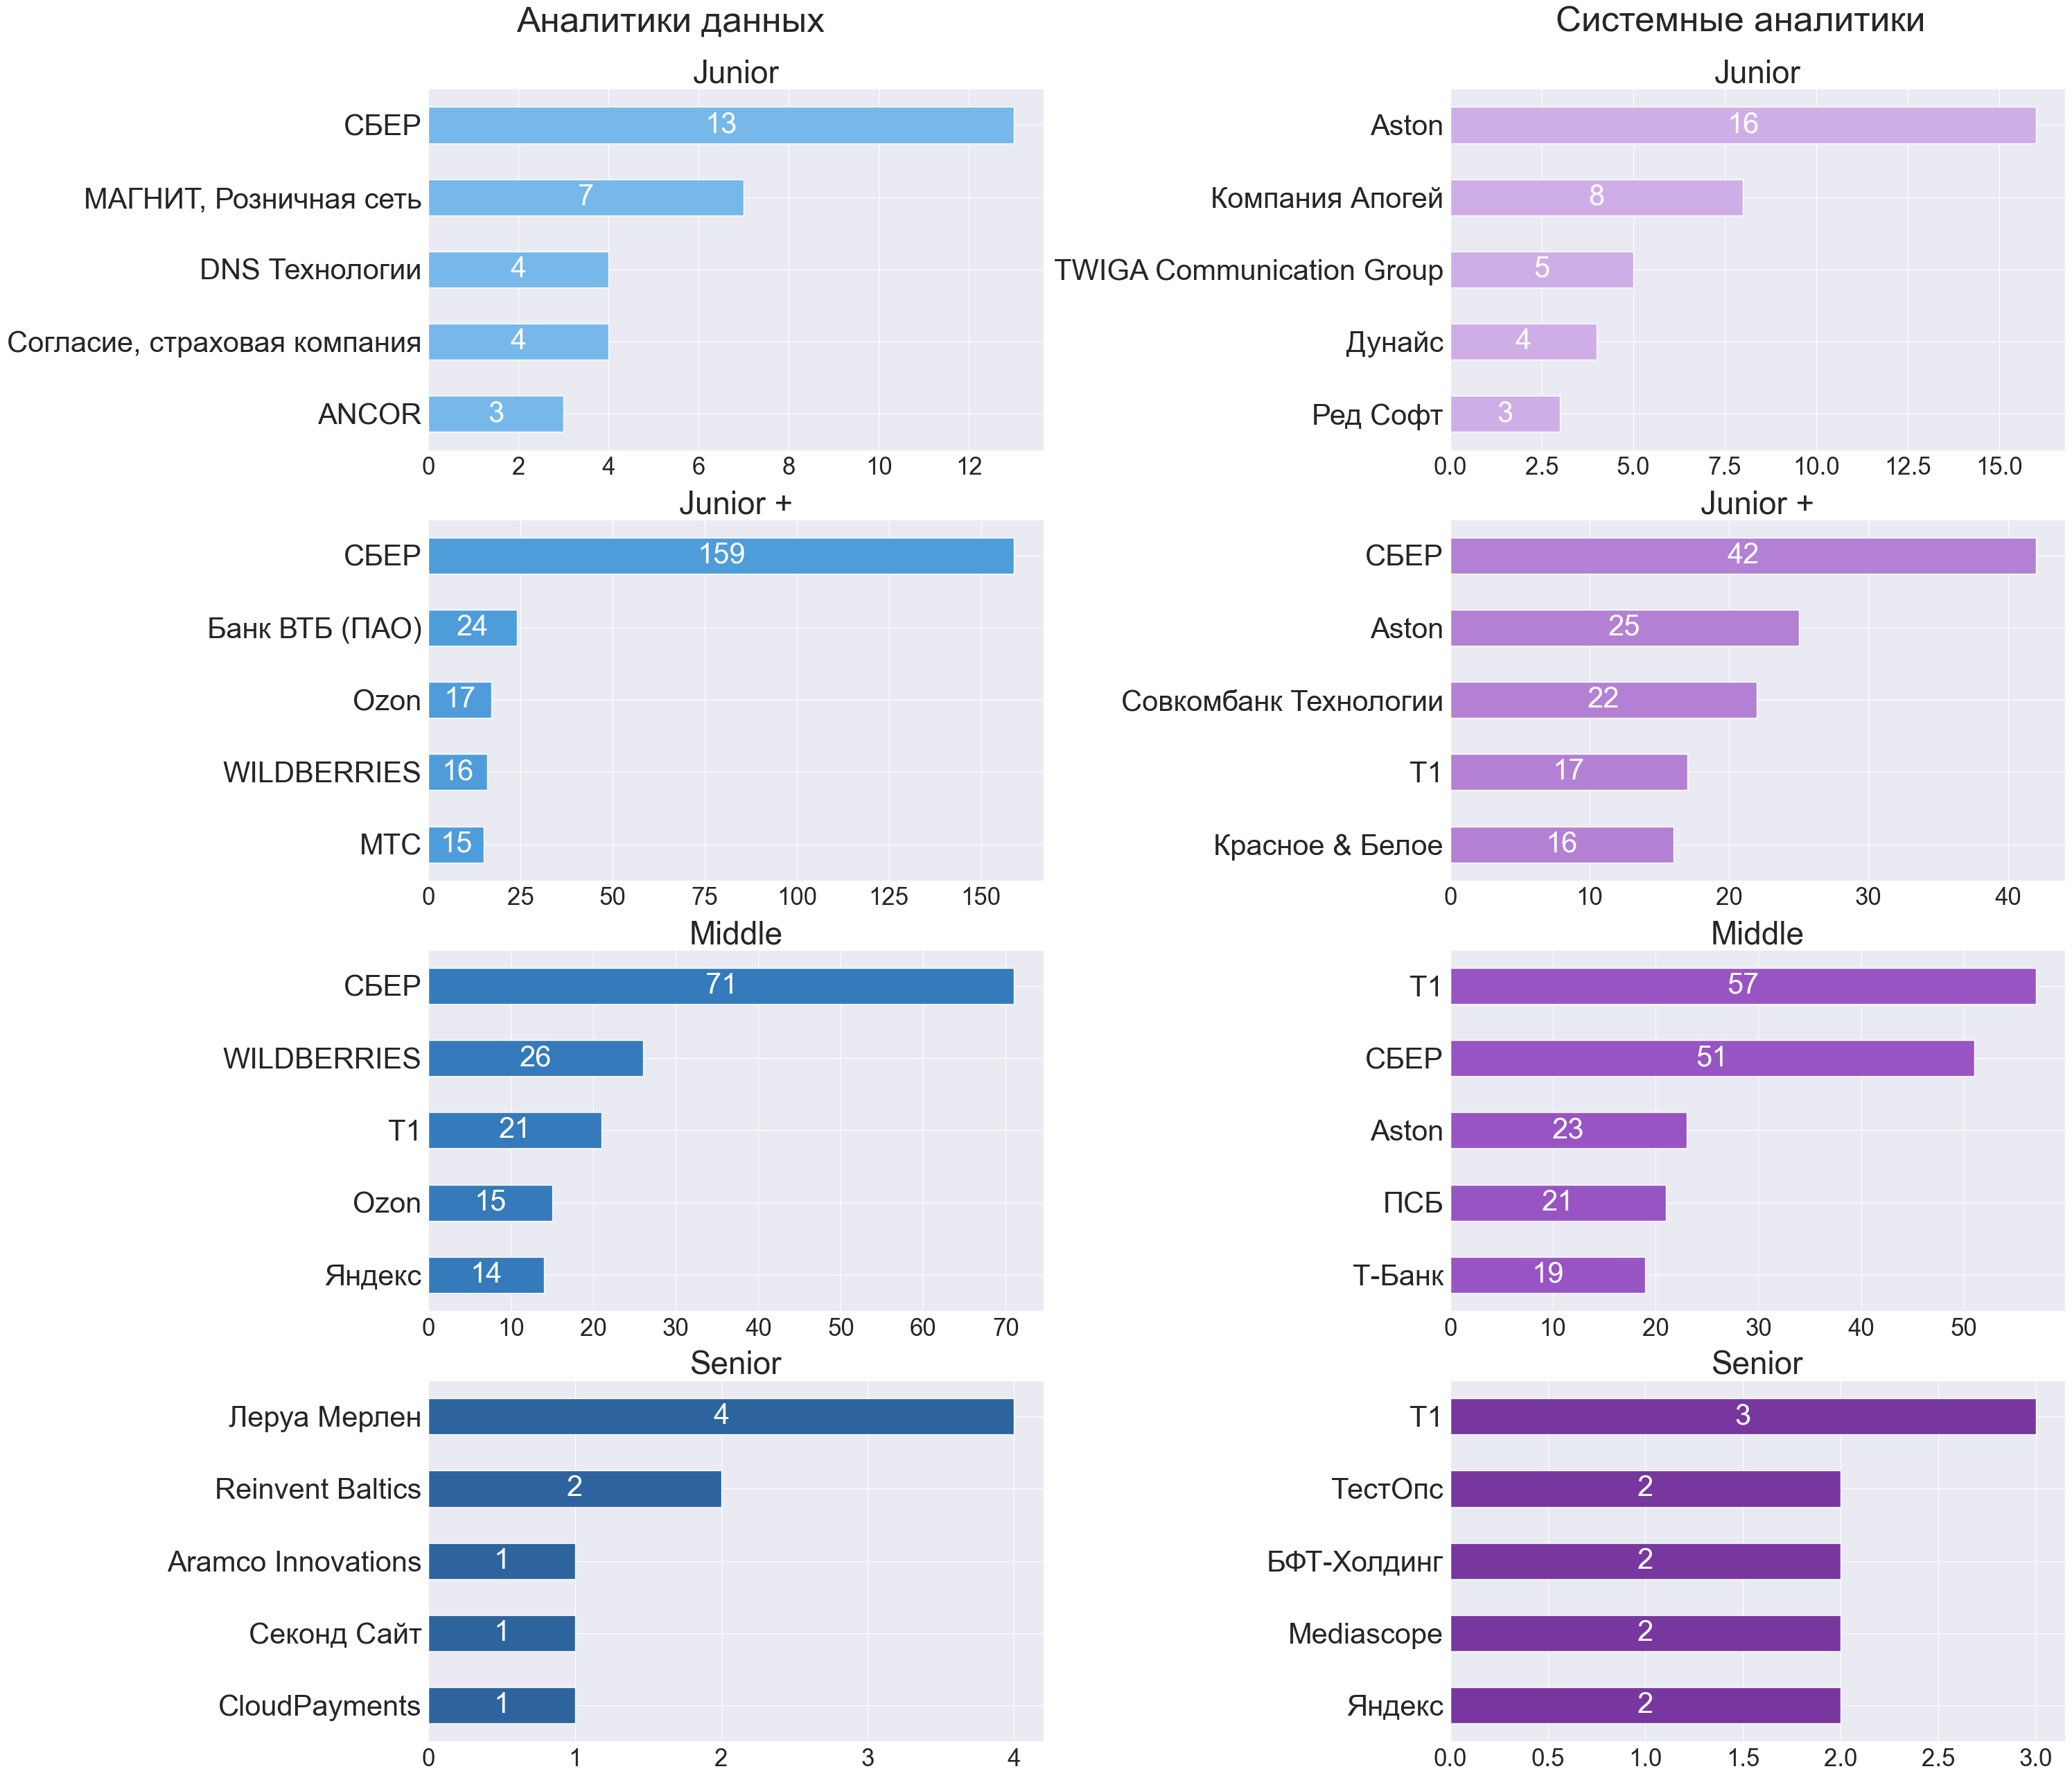

In [60]:
plot_pivot_table(employer_da, employer_sa, 'Работодатели')

Наибольшее количество вакансий сразу для 3-х грейдов предоставляет "СБЕР" для должности аналитика данных - Junior, Junior+ и Middle. Особый отрыв по числу вакансий заметен для грейдов Junior+ и Middle - количество объявлений от "СБЕР" - 159 и 71, затем "Банк ВТБ (ПАО)" - 24 вакансии и "WILDBERRIES" - 26 для соответствующих грейдов.

Для системных аналитиков в топ-работодателей по количеству объявлений входят: "Aston", "СБЕР" и "T1" для грейдов Junior, Junior+ и Middle соответственно.

Для грейда Senior в обоих должностях не прослеживается явный лидер работодатель в силу ограниченного количества объявлений.

### Город

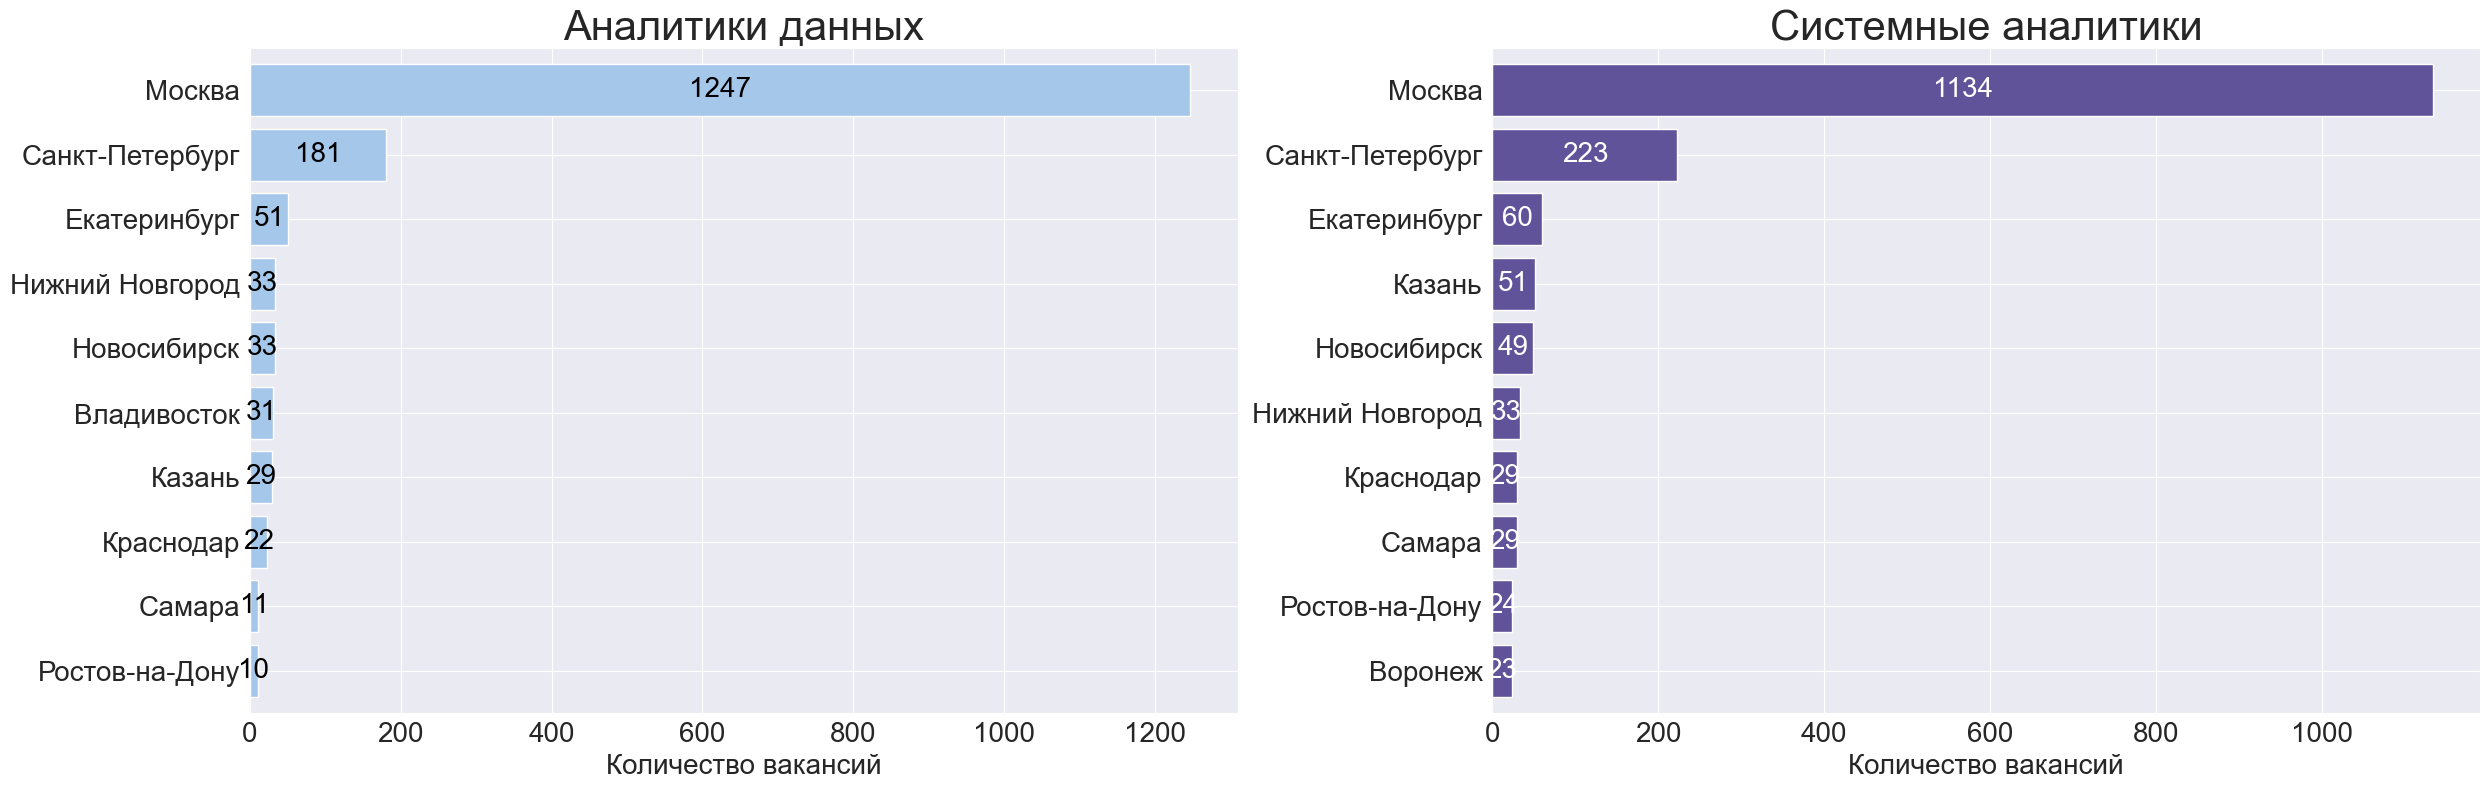

In [61]:
area_df = set_typical_job(df_da, df_sa, 'area', 'Город', 'Популярные города')
plot_typical_job(area_df, 'Город')

С большим отрывом от других городов лидером является Москва, также большой выбор вакансий в городе Санкт-Петербург как для аналитиков данных, так и для системных аналитиков. Для двух должностей в топ попали следующие города - Екатеринбург, Нижний Новгород, Новосибирск, Казань, Краснодар, Самара и Ростов-на-Дону.

In [62]:
area_da = build_pivot_table(df_da, 'area', 'Город', 'Топ-городов')
area_sa = build_pivot_table(df_sa, 'area', 'Город', 'Топ-городов')

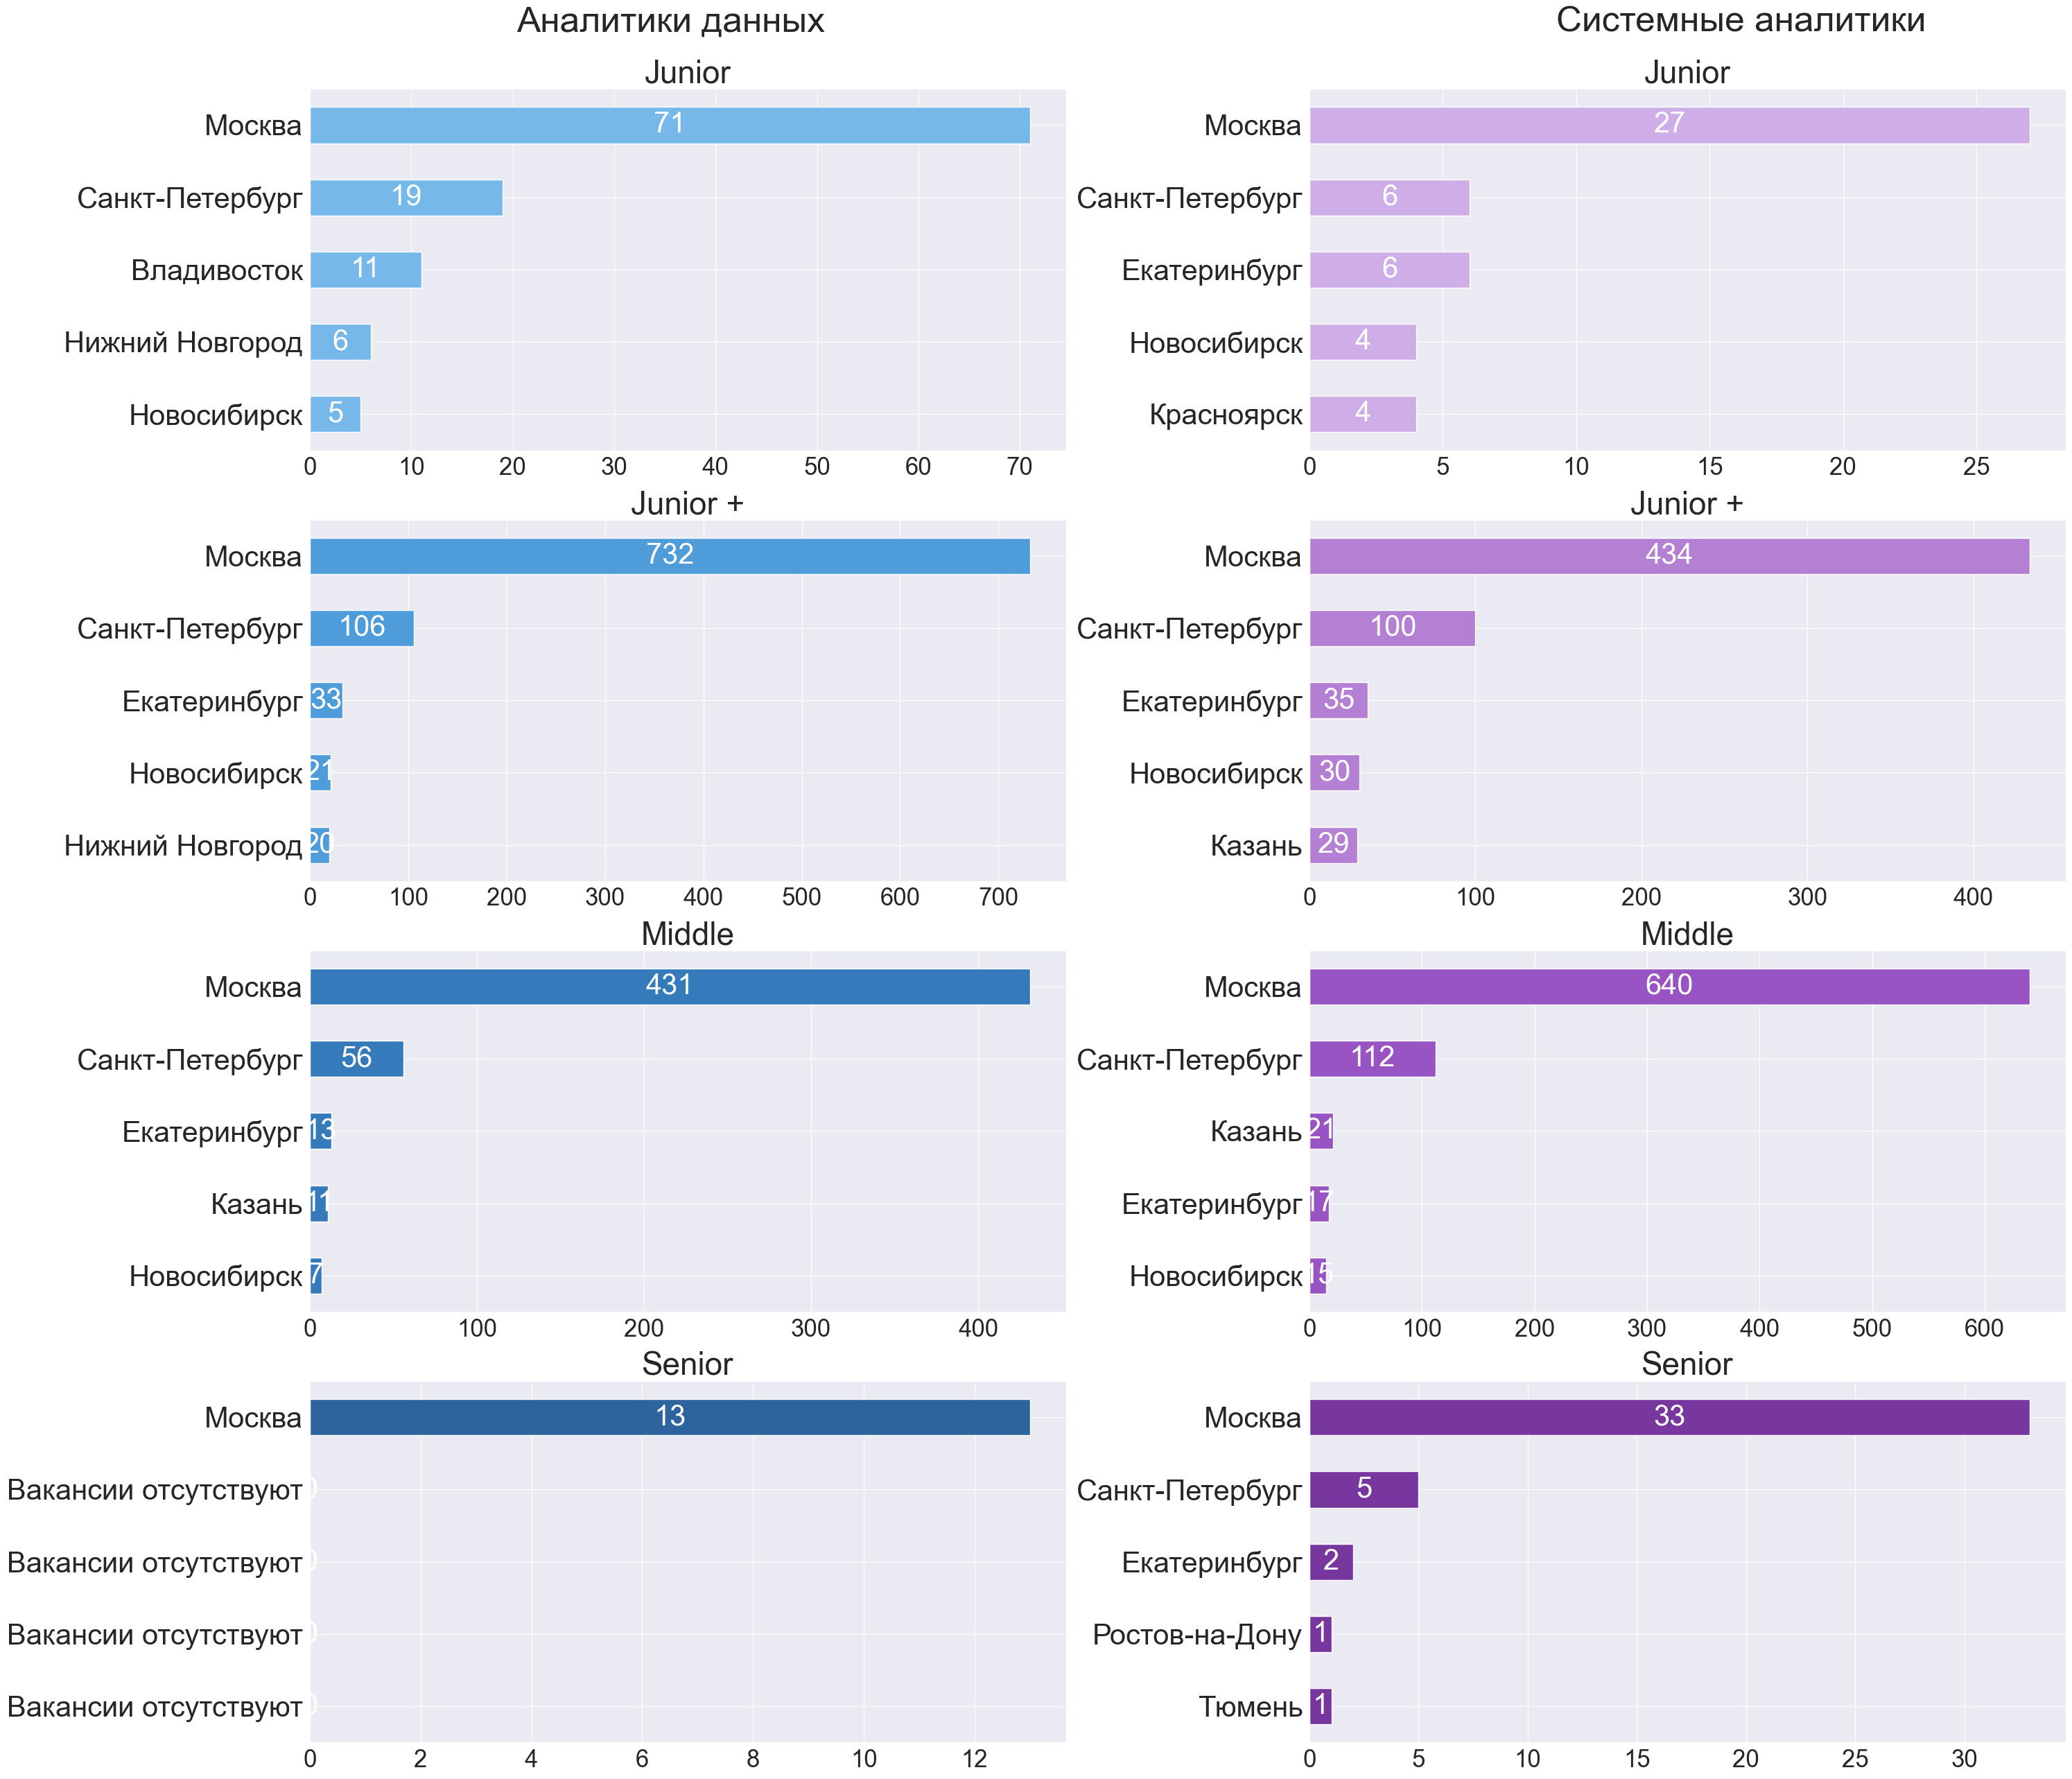

In [63]:
plot_pivot_table(del_nan(area_da, 'Город'), del_nan(area_sa, 'Город'), 'Город')

Для всех грейдов лидером по выбору вакансий стала Москва и Санкт-Петербург (за исключением грейда Senior для аналитиков данных). Для многих грейдов в топ попали следующие города - Екатеринбург, Казань, Новосибирск, Нижний Новгород.

### Зарплата

In [64]:
salary_df_da = df_da.query('salary_bin != "ЗП не указана"')
salary_df_sa = df_sa.query('salary_bin != "ЗП не указана"')

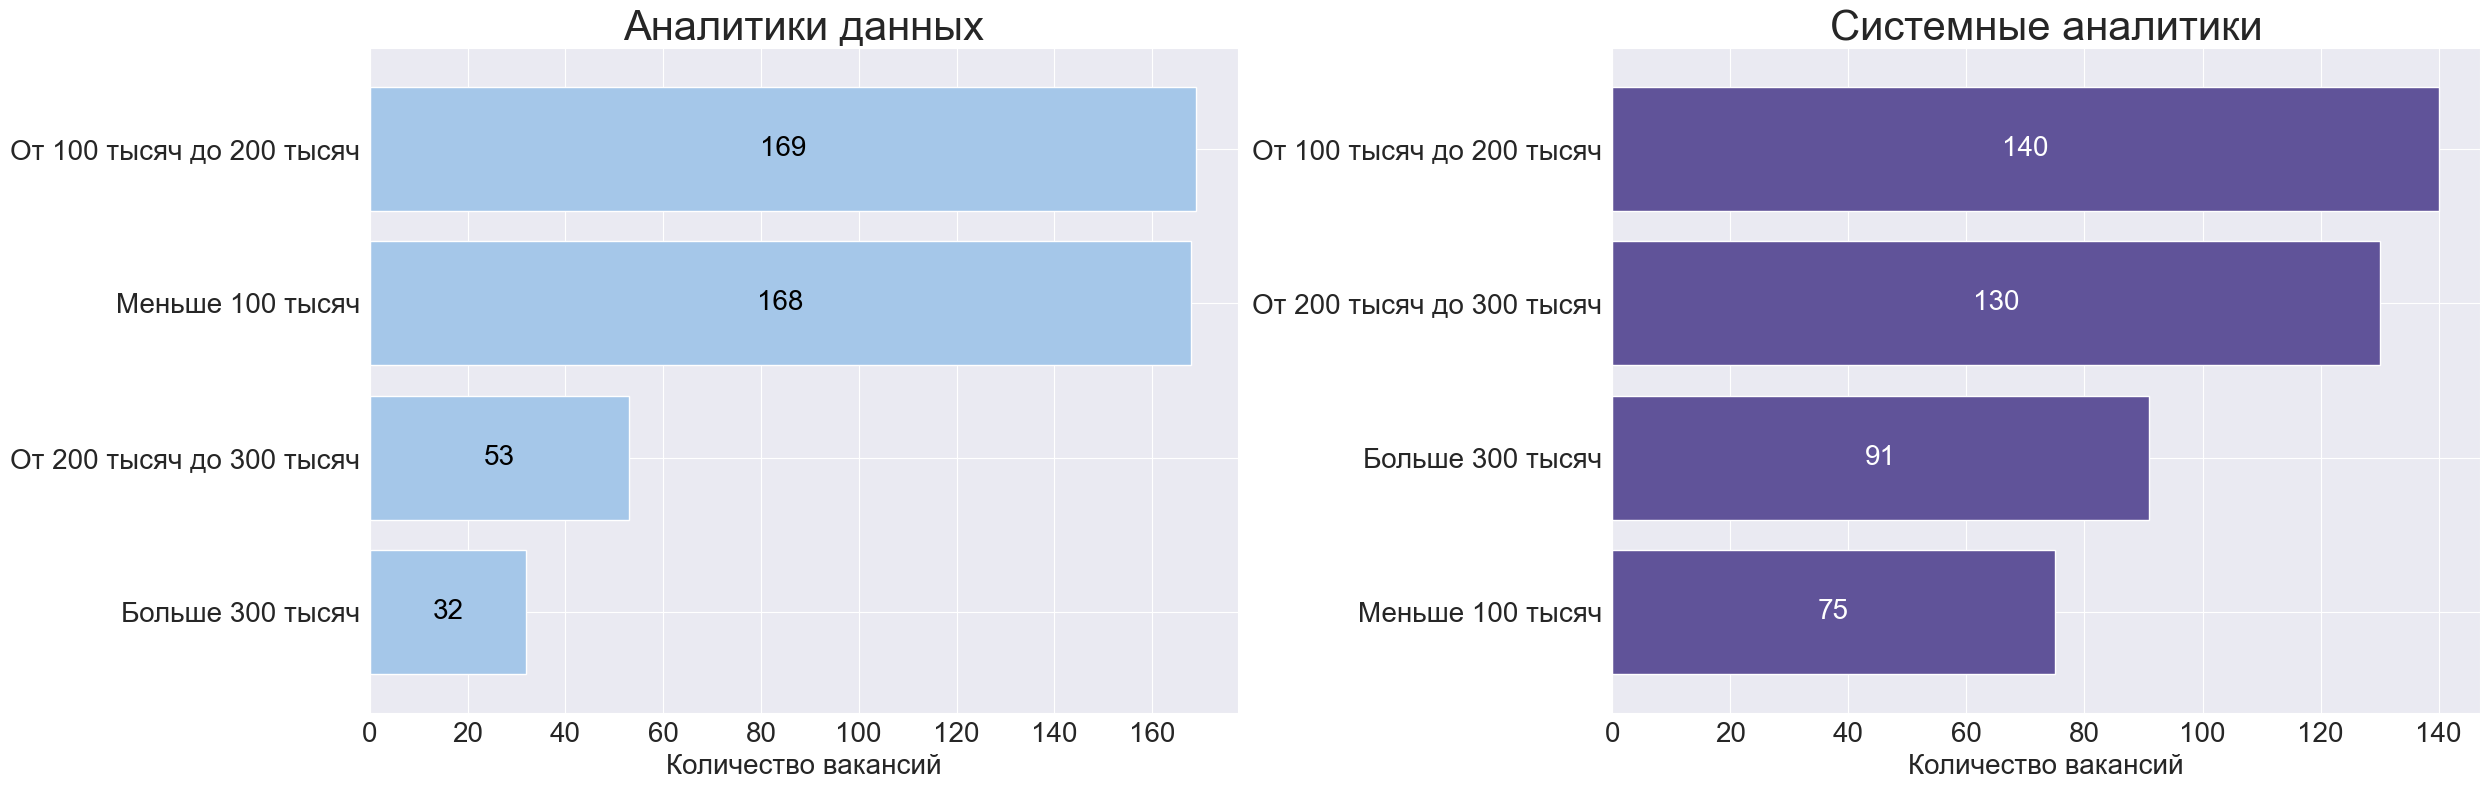

In [65]:
salary_df = set_typical_job(salary_df_da, salary_df_sa, 'salary_bin', 'Зарплата', 'Распределение зарплат')
plot_typical_job(salary_df, 'Зарплата')

Для аналитиков данных типичный зарплатный диапазон - от 100 до 200 тыс. руб. и меньше 100 тыс. руб., оба диапазона встречаются практически с одинаковой частотой (разница в одну вакансию). Для системных аналитиков наиболее встречаемы следующие диапазоны: от 100 до 200 тыс. руб. и от 200 до 300 тыс. руб.

Напрашивается вывод, что системные аналитики получают зарплату больше аналитиков данных, но стоит пересмотреть долю грейдов для двух должностей - для аналитиков данных в датафрейме чаще встречаются вакансии с грейдом младше, чем для системных аналитиков. Возможно, подобное распределение сильно повлияло на результаты заработной платы.

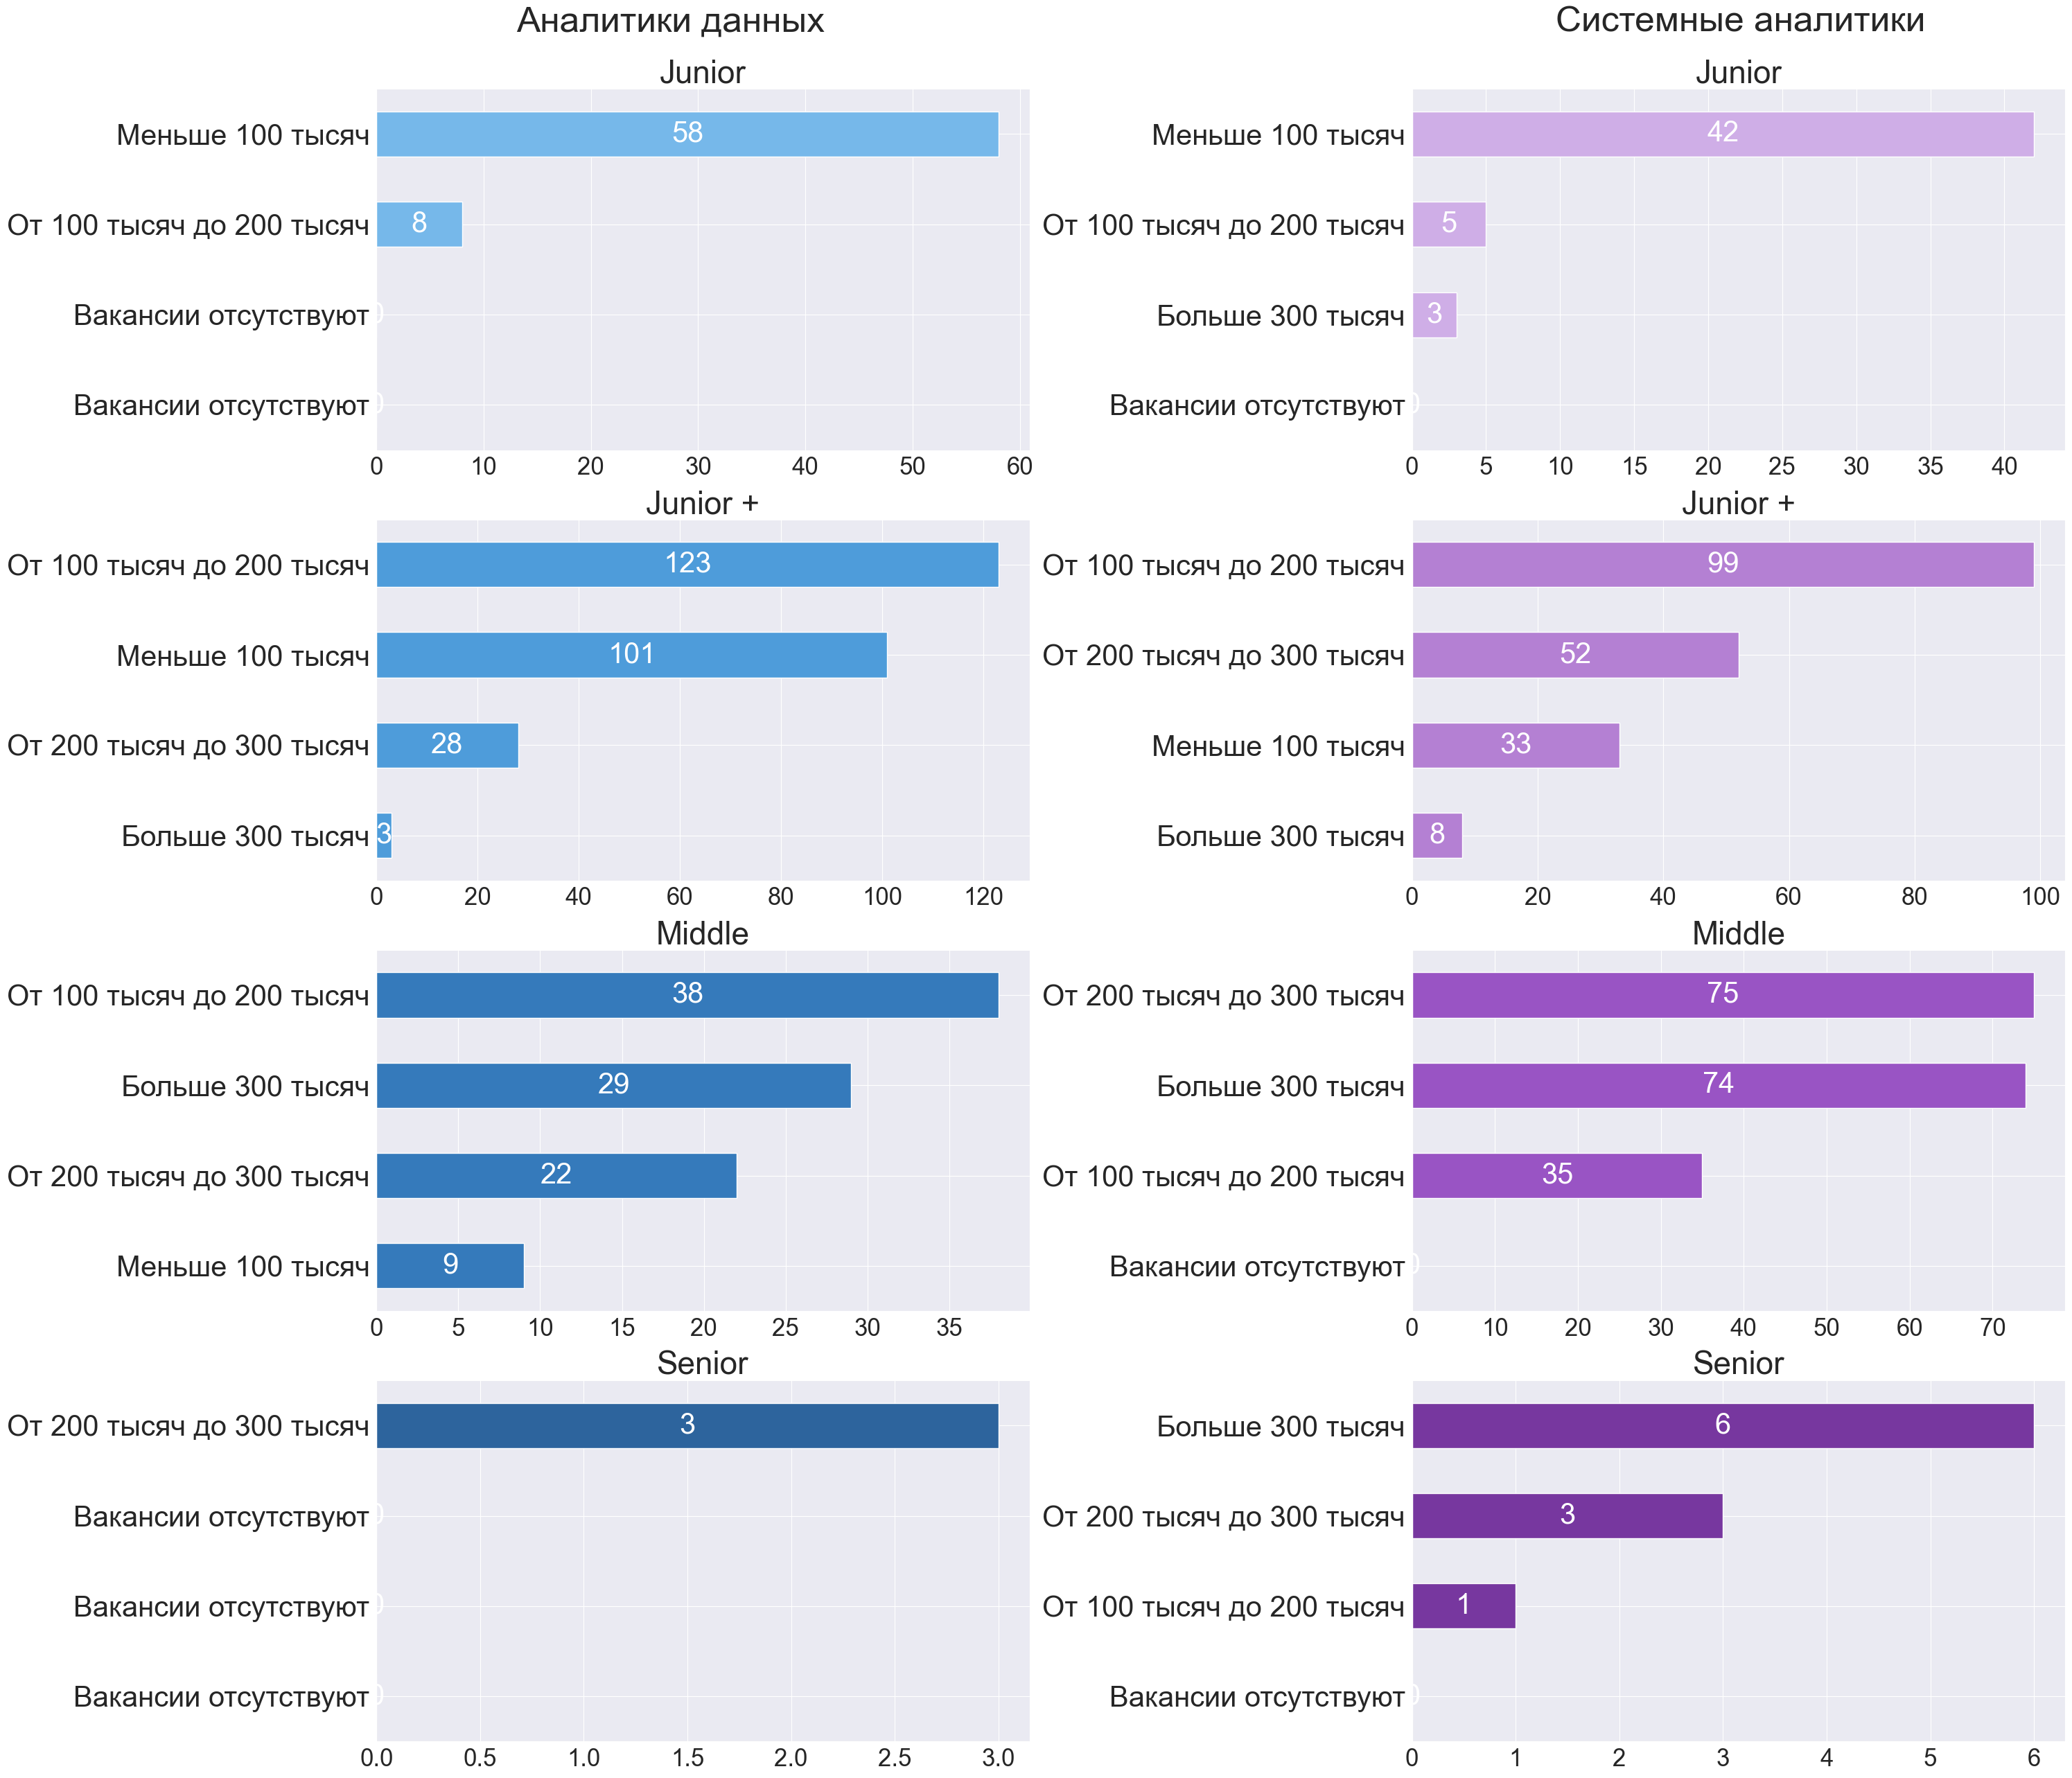

In [66]:
salary_da = build_pivot_table(salary_df_da, 'salary_bin', 'Зарплата', 'Распределние зарплаты')
salary_sa = build_pivot_table(salary_df_sa, 'salary_bin', 'Зарплата', 'Распределние зарплаты')

plot_pivot_table(del_nan(salary_da, 'Зарплата'), del_nan(salary_sa, 'Зарплата'), 'Зарплата')

В разрезе грейдов наиболее встречаемые зарплаты ожидаемо растут с увеличением опыта специалиста. Обе должности с грейдом Junior чаще получают менее 100 тыс. руб. Для грейда Junior+ чаще устанавливаются зарплаты от 100 до 200 тыс. руб., но далее для аналитиков данных в вакансиях встречается зарплата до 100 тыс. руб., а для системных аналитиков от 200 до 300 тыс. руб. Middle специалисты аналитиков данных ожидают встретить зарплату от 100 до 200 тыс. руб., а системные аналитики от 200 тыс. руб. и выше. Для Грейдов Senior зарплаты от 200 тыс. руб. и выше.

Таким образом, в рассматриваемых датафреймах, системные аналитики получают больше на вакансиях с грейдом от Junior+ и выше, чем аналитики данных.

### График работы

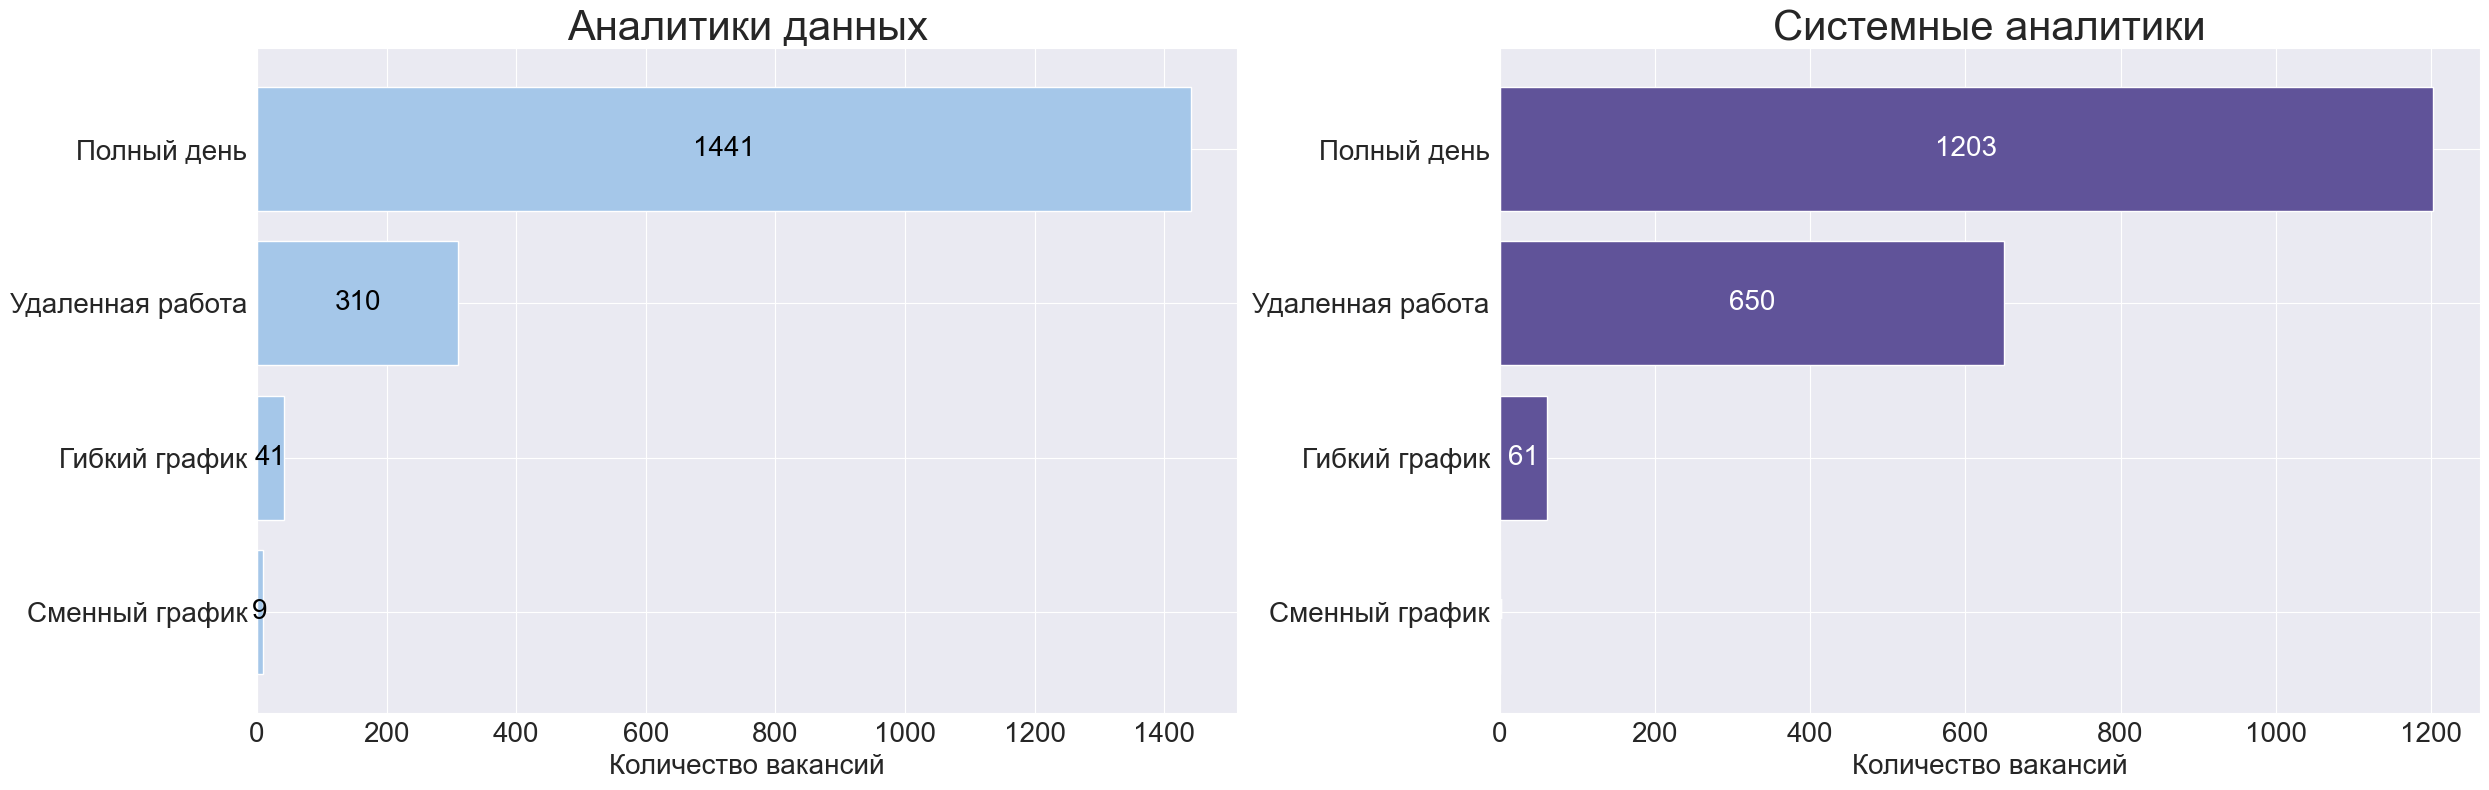

In [67]:
schedule_df = set_typical_job(df_da, df_sa, 'schedule', 'График работы', 'Распределение графиков работы')
plot_typical_job(schedule_df, 'График работы')

Подавляющее большинство вакансий имеют полный день занятости, затем следует удаленная работа, в немногих вакансиях встречается гибкий график и для аналитиков данных имеется сменный график, представленный в 9 вакансиях.

In [68]:
schedule_da = build_pivot_table(df_da, 'schedule', 'График работы', 'график работы')
schedule_sa = build_pivot_table(df_sa, 'schedule', 'График работы', 'график работы')

В разрезе грейдов все вакансии имеют одинаковый характер распределения. Работодатели ожидают полный рабочий день от нанимаемых специальстов всех грейдов.

### Тип занятости

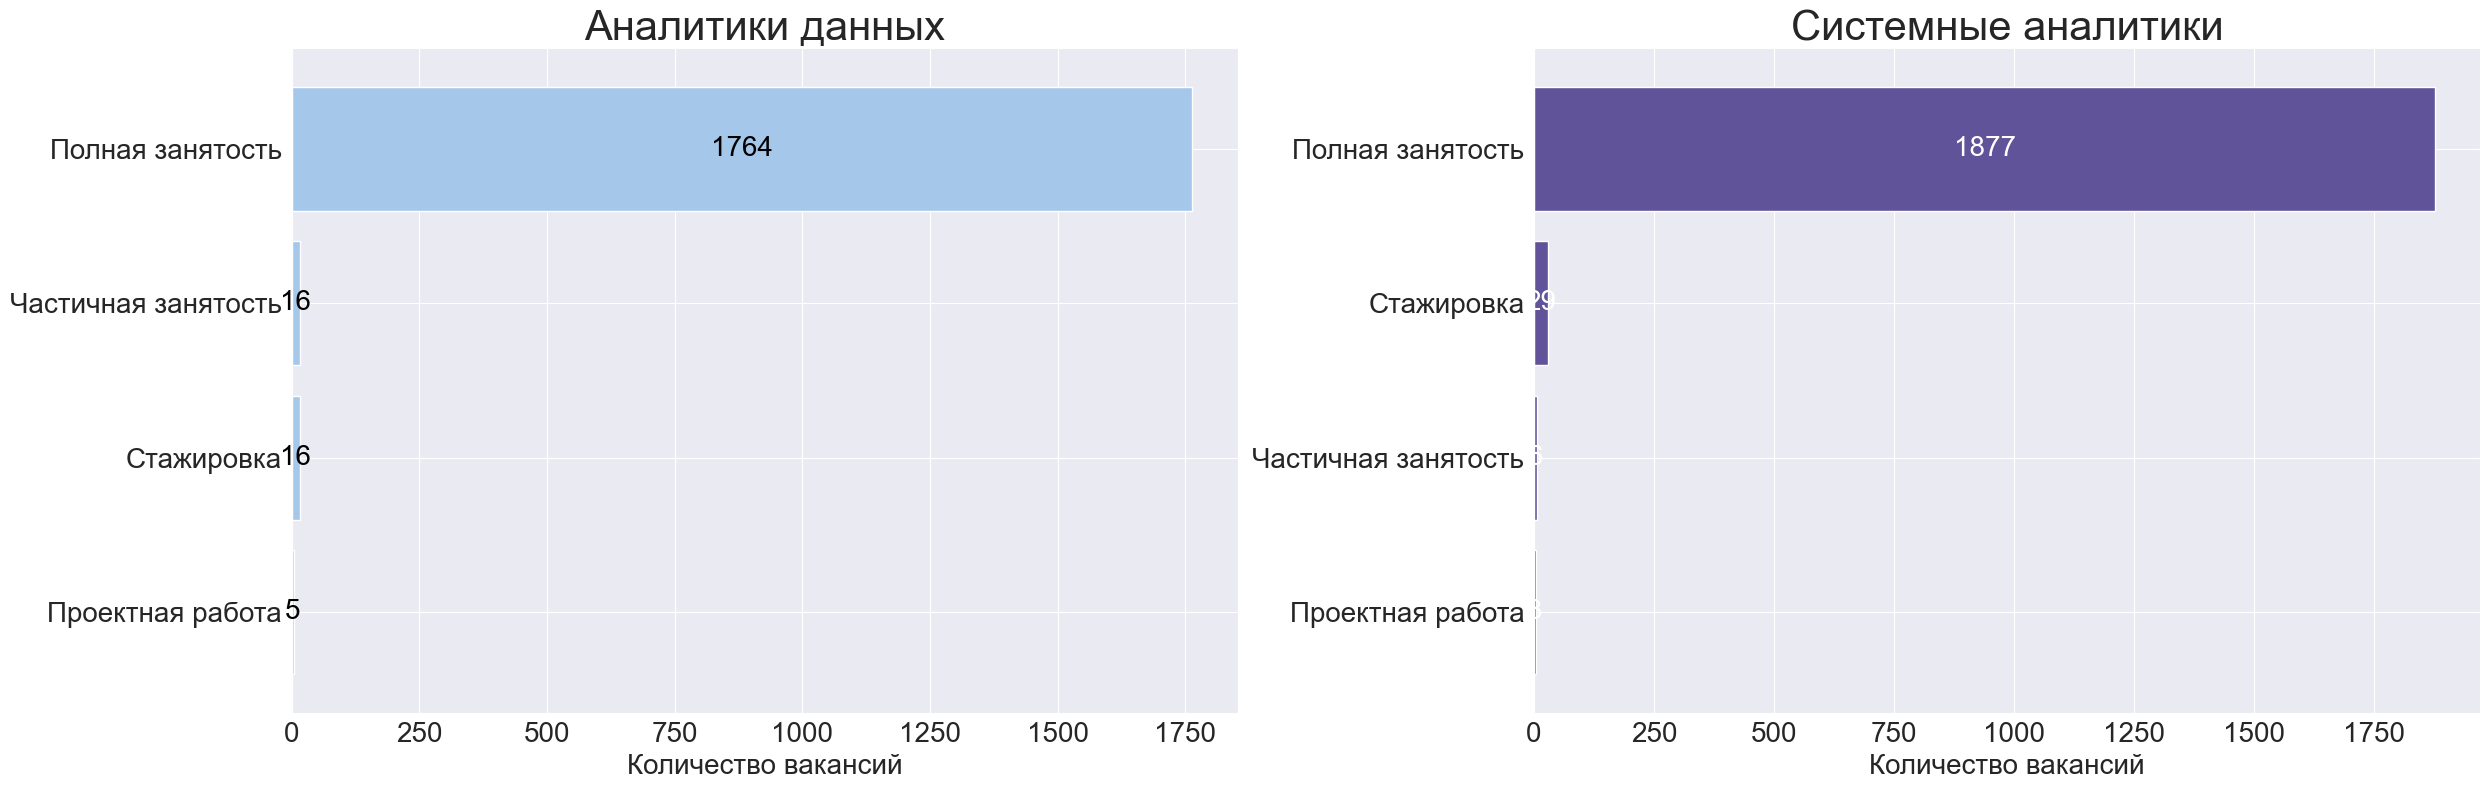

In [69]:
employment_df = set_typical_job(df_da, df_sa, 'employment', 'Тип занятости', 'Тип занятости')
plot_typical_job(employment_df, 'Тип занятости')

Практически все вакансии имеют полную занятость, но также можно найти вариант частичной занятости, стажировки или проектой работы.

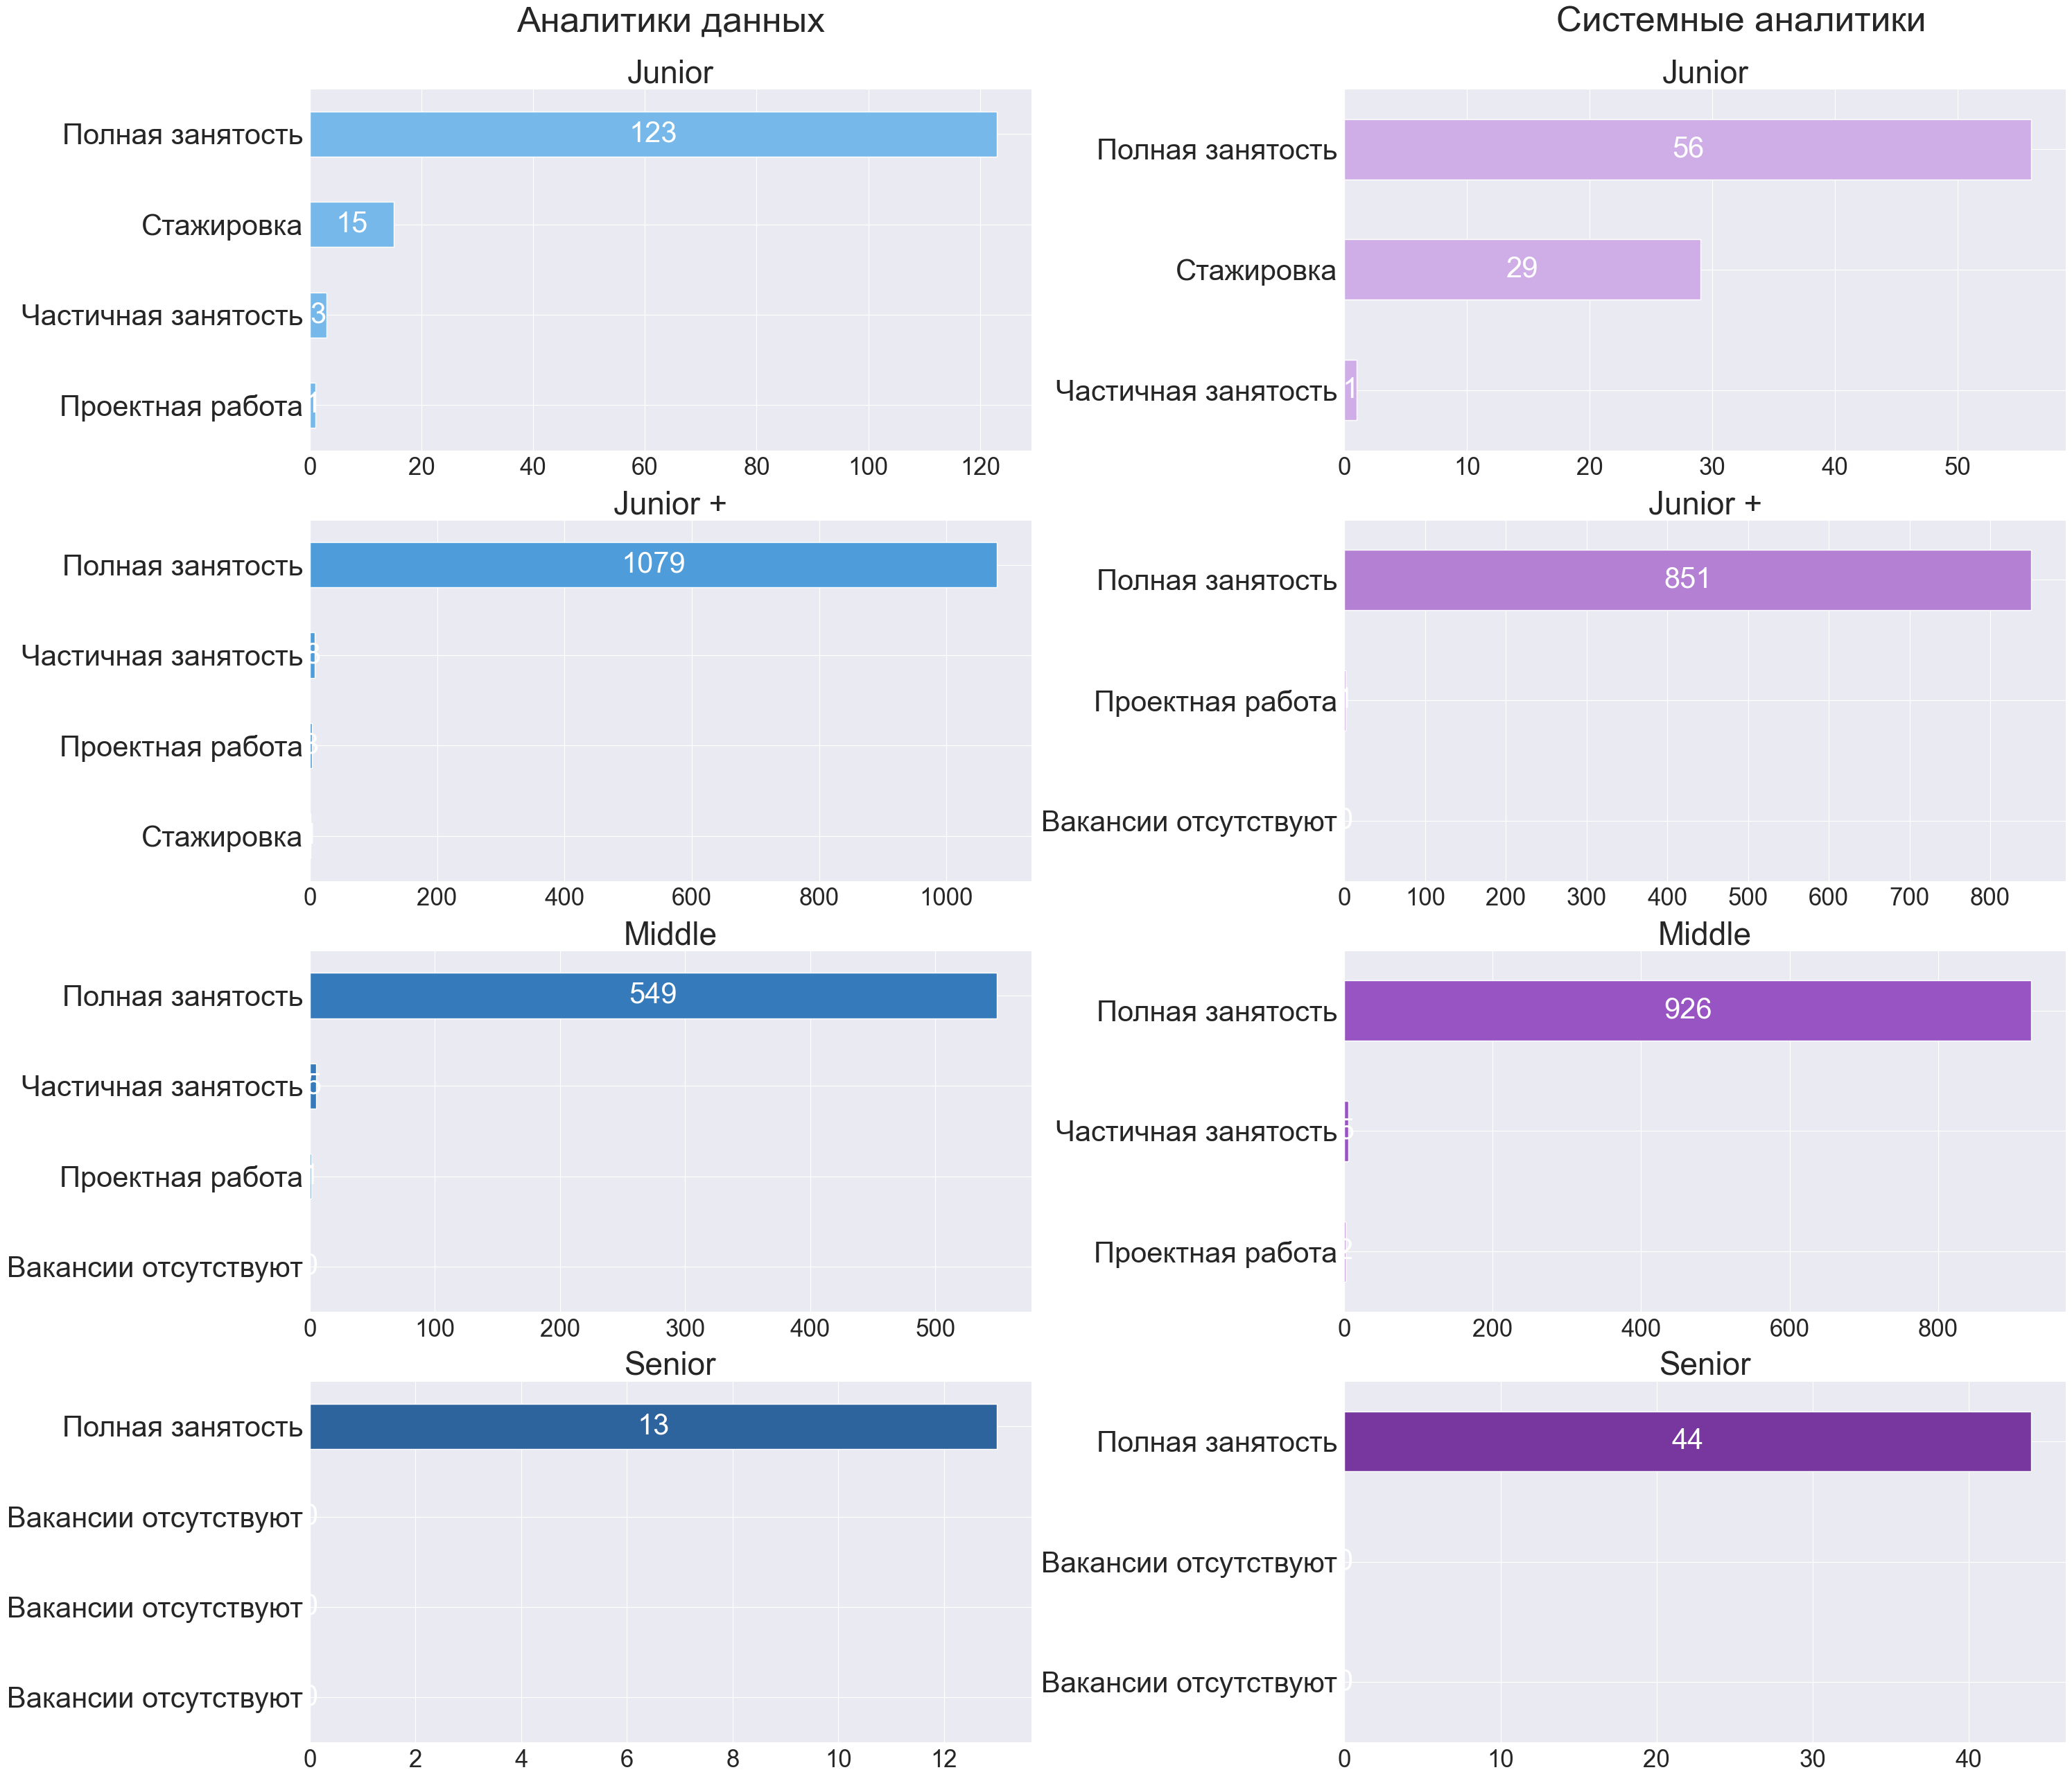

In [70]:
employment_da = build_pivot_table(df_da, 'employment', 'Тип занятости', 'Тип занятости')
employment_sa = build_pivot_table(df_sa, 'employment', 'Тип занятости', 'Тип занятости')

plot_pivot_table(del_nan(employment_da, 'Тип занятости'), del_nan(employment_sa, 'Тип занятости'), 'Тип занятости')

Небольшое количество стажировок из предыдущего сета графиков наиболее часто встречается для грейда Junior без опыта работы. Для всех грейдов полная занятость встречается в большинстве вакансий.

#### Навыки специалистов

In [71]:
top_skills_da = set_top_skills(df_da)
top_skills_sa = set_top_skills(df_sa)

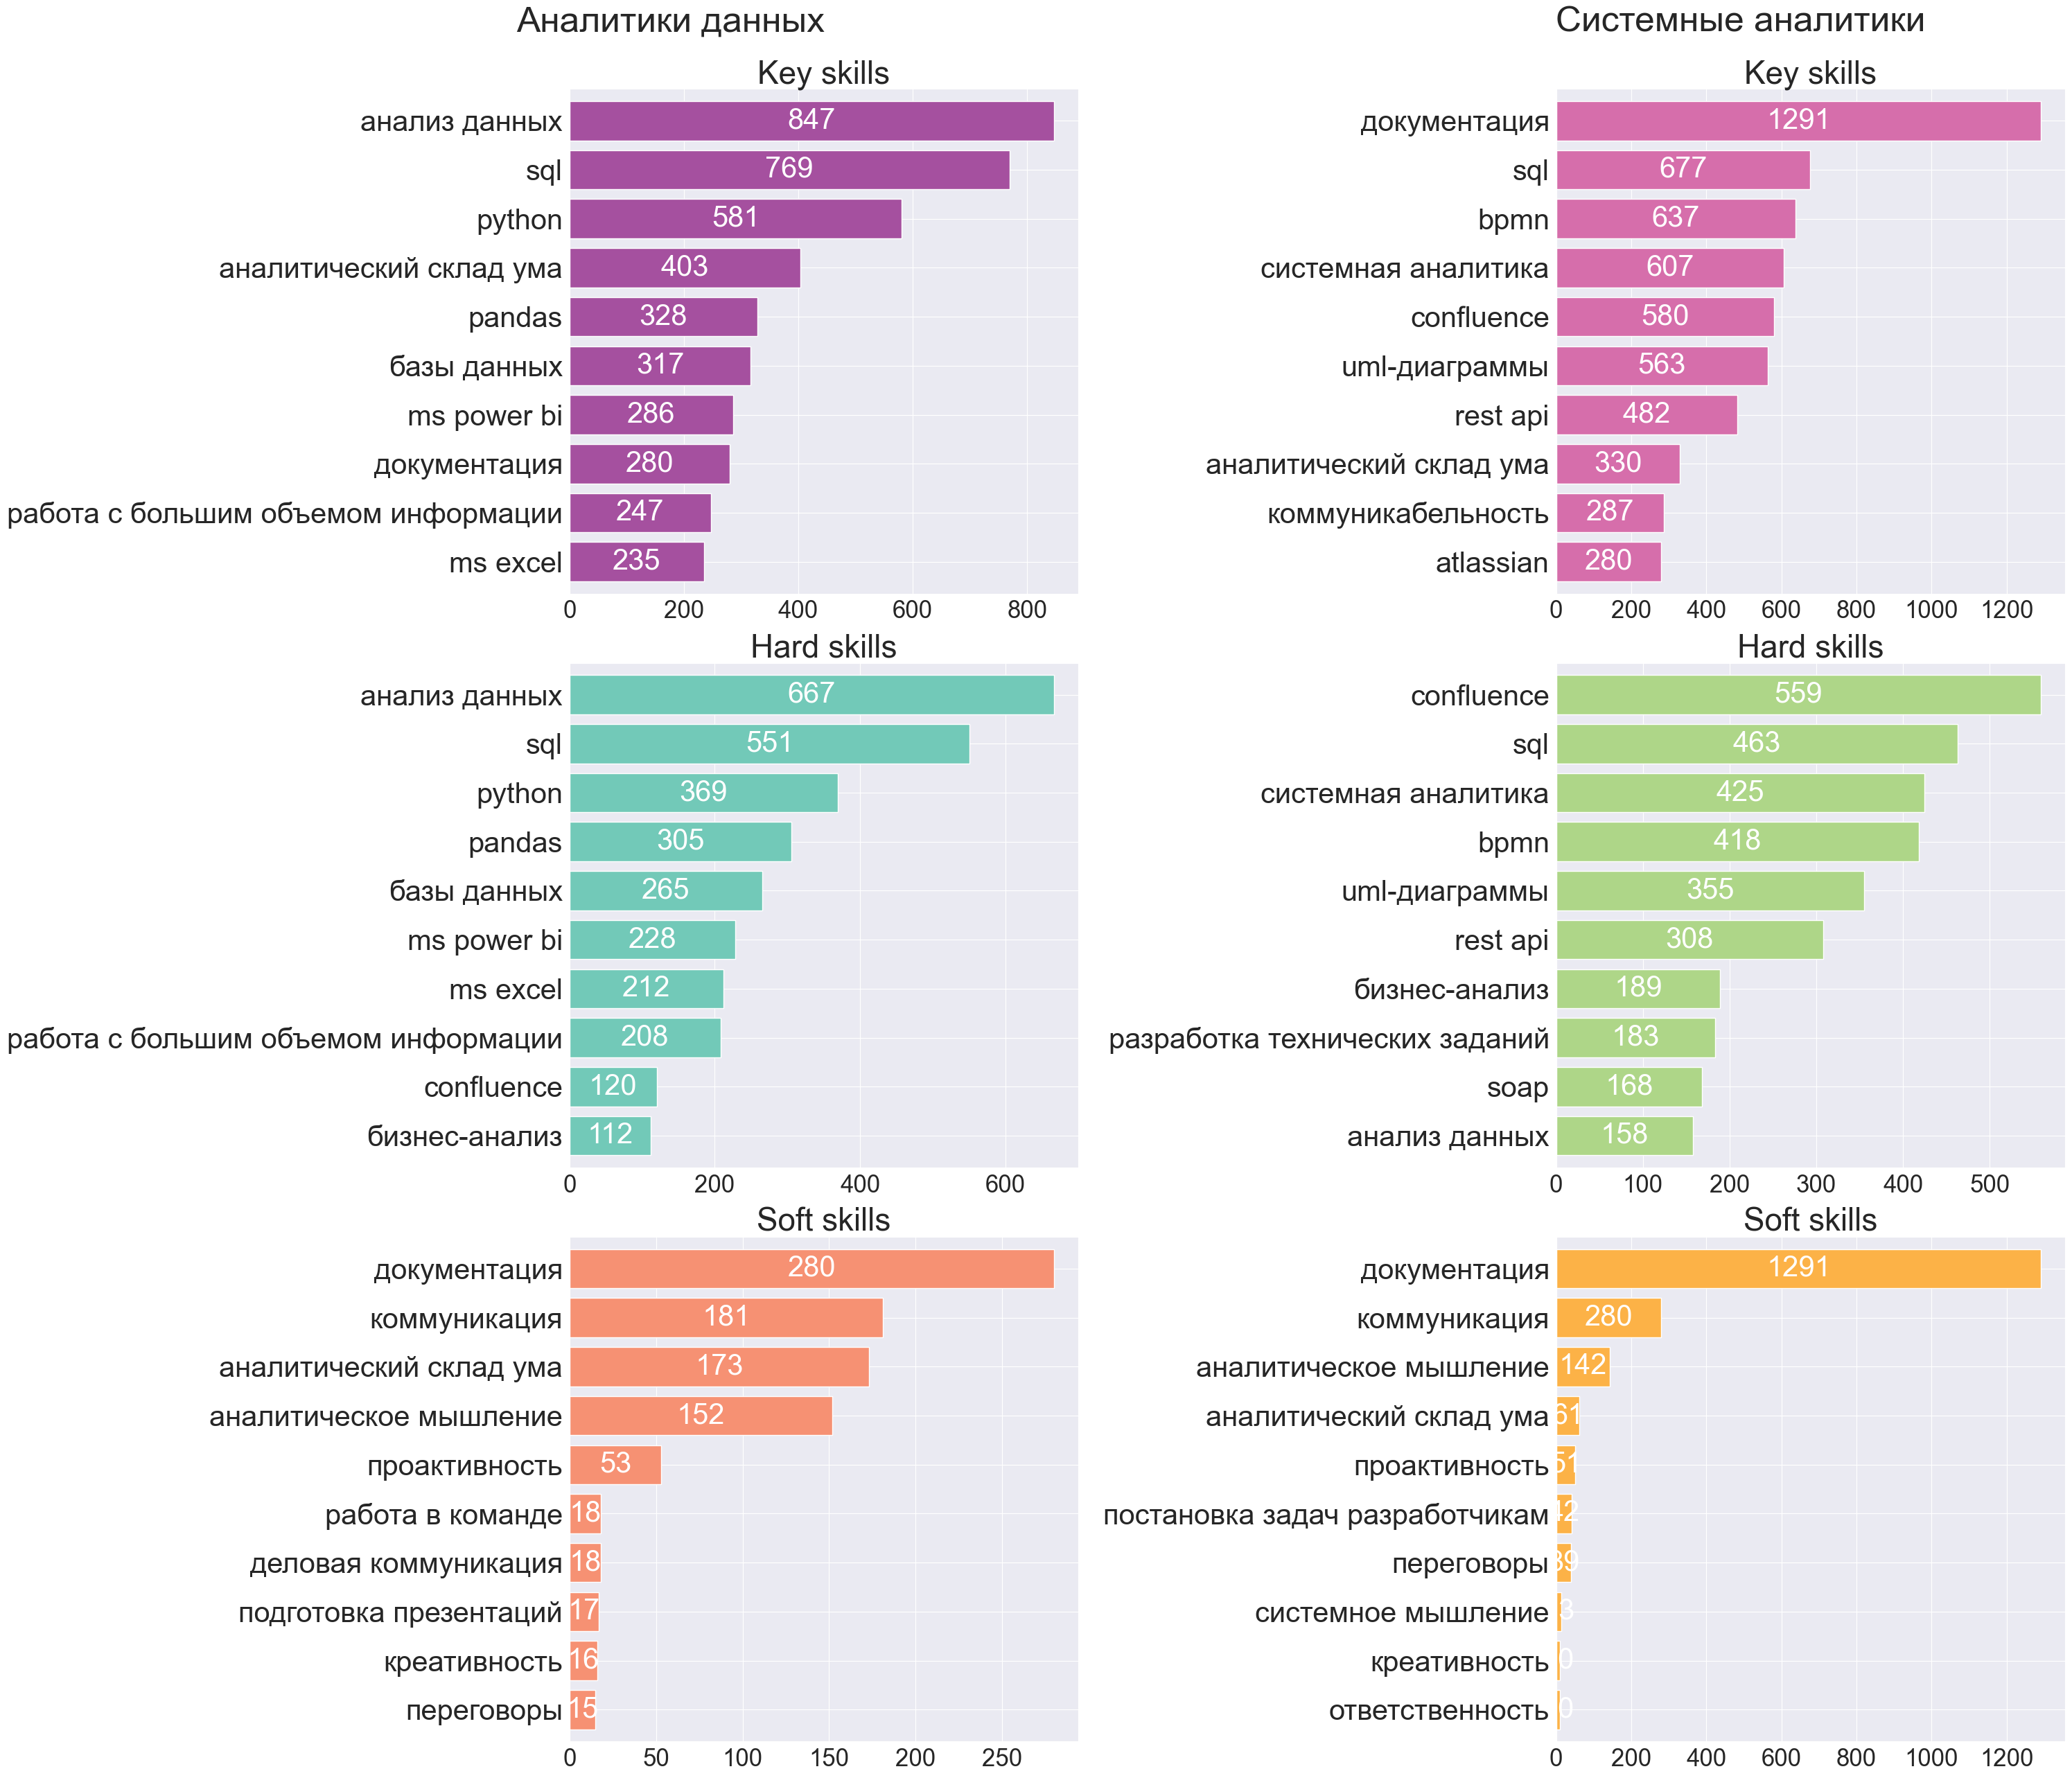

In [72]:
plot_skills(top_skills_da, top_skills_sa)

Ключевым навыком для аналитиков данных стал анализ данных (сюрприз!), для системных аналитиков - документация.

Ключевые навыки в большинстве вакансий обоих должностей представлены hard-skills. Для аналитиков данных стек hard-навыков состоит из sql, python, pandas, power bi, excel, а также работа с базами данных и большим объемом информации, в топ навыков попали следующие soft-skills - аналитический склад ума (2x сюрприз!) и документация.

Для системных аналитиков сформировался следующий стек hard-skills - sql, bpmn, confluence, uml-диаграммы, rest api, atlassian, системная аналитика (3x сюрприз!). Soft-skills - документация, аналитический склад ума и коммуникабельность.

Практически все навыки из общего рейтинга составили hard-skills аналитиков данных и системных аналитиков. В soft-skills также приветствуются проактивность, креативность и навык вести переговоры.

In [73]:
top_hard_skills_experience_da = set_top_skills_experience(df_da, 'hard_skills_from_description')
top_hard_skills_experience_sa = set_top_skills_experience(df_sa, 'hard_skills_from_description')

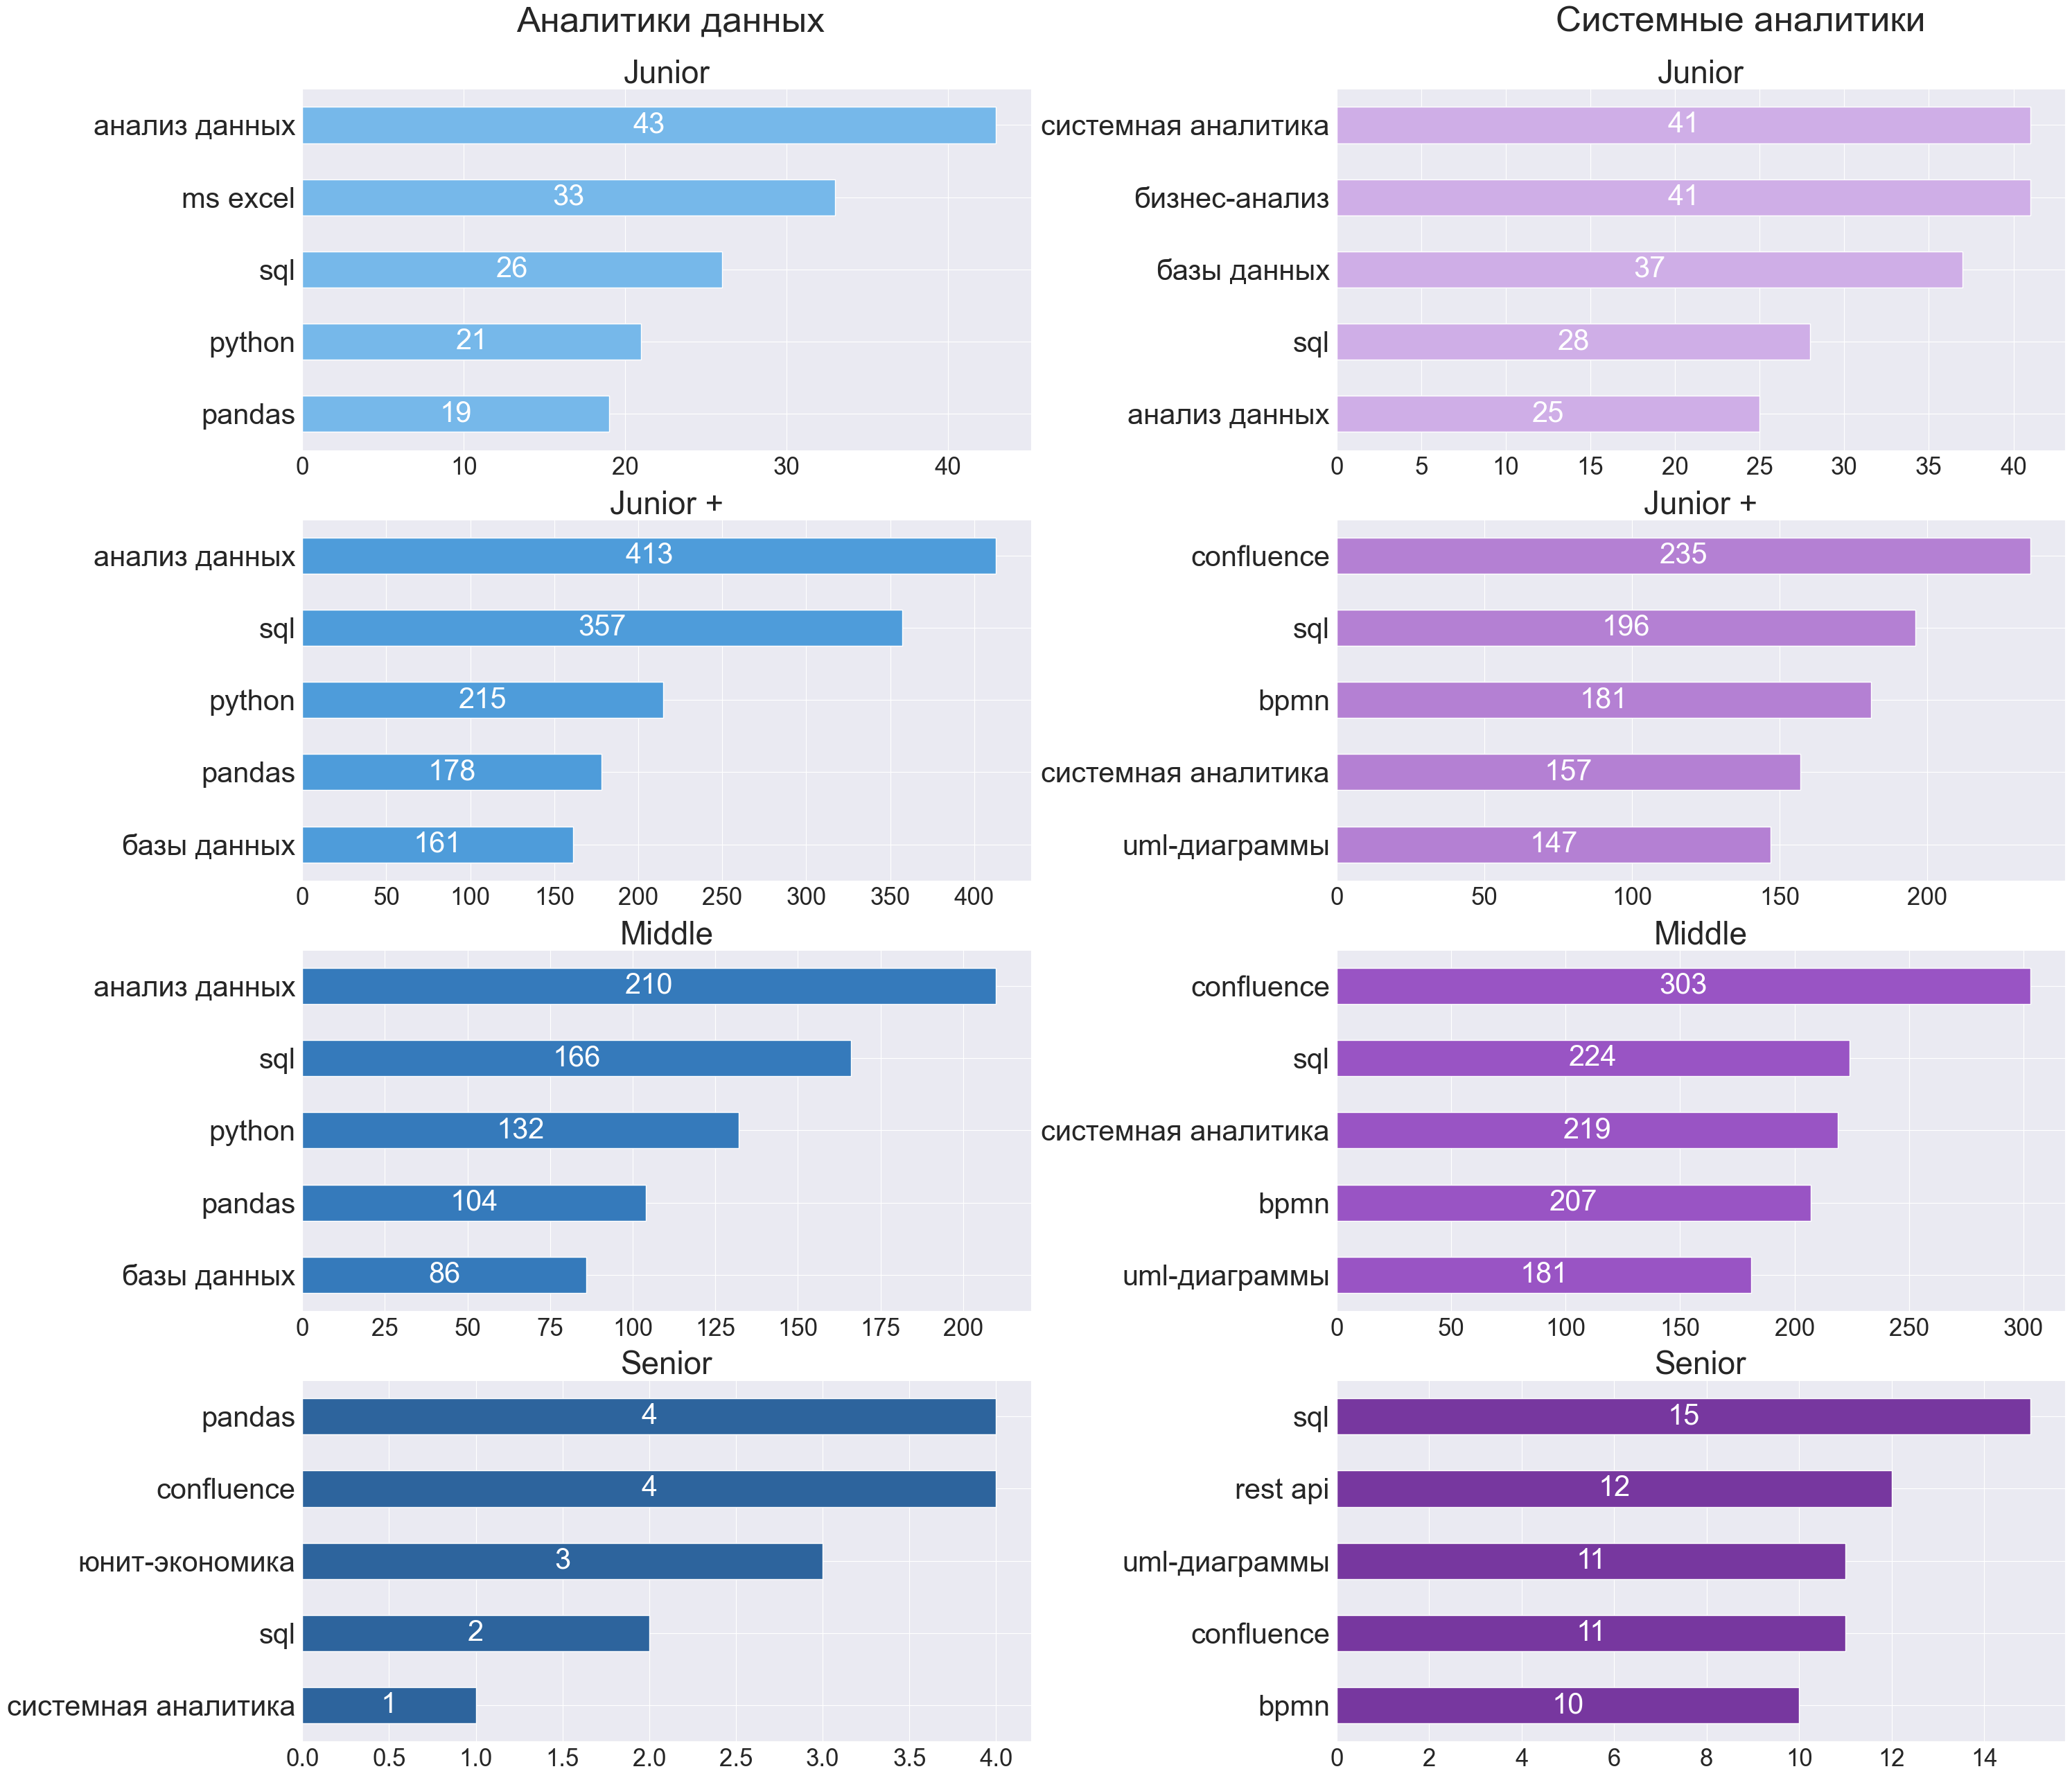

In [74]:
plot_pivot_table(top_hard_skills_experience_da, top_hard_skills_experience_sa, 'Аналитик данных')

Анализ данных для аналитиков данных и системная аналитика для системных аналитиков - наше все!

В разрезе грейдов топ стек технологий практически повторяется для всех грейдов соответствующих должностей. Меняются некоторые навыки с переходом к новому грейду, но фундамент непоколебим. Для аналитиков данных - pandas, sql, python, работа с базами данных. Для системных аналитиков -  sql, bpmn, confluence, uml-диаграммы. Это база!

In [75]:
top_soft_skills_experience_da = set_top_skills_experience(df_da, 'soft_skills_from_description')
top_soft_skills_experience_sa = set_top_skills_experience(df_sa, 'soft_skills_from_description')

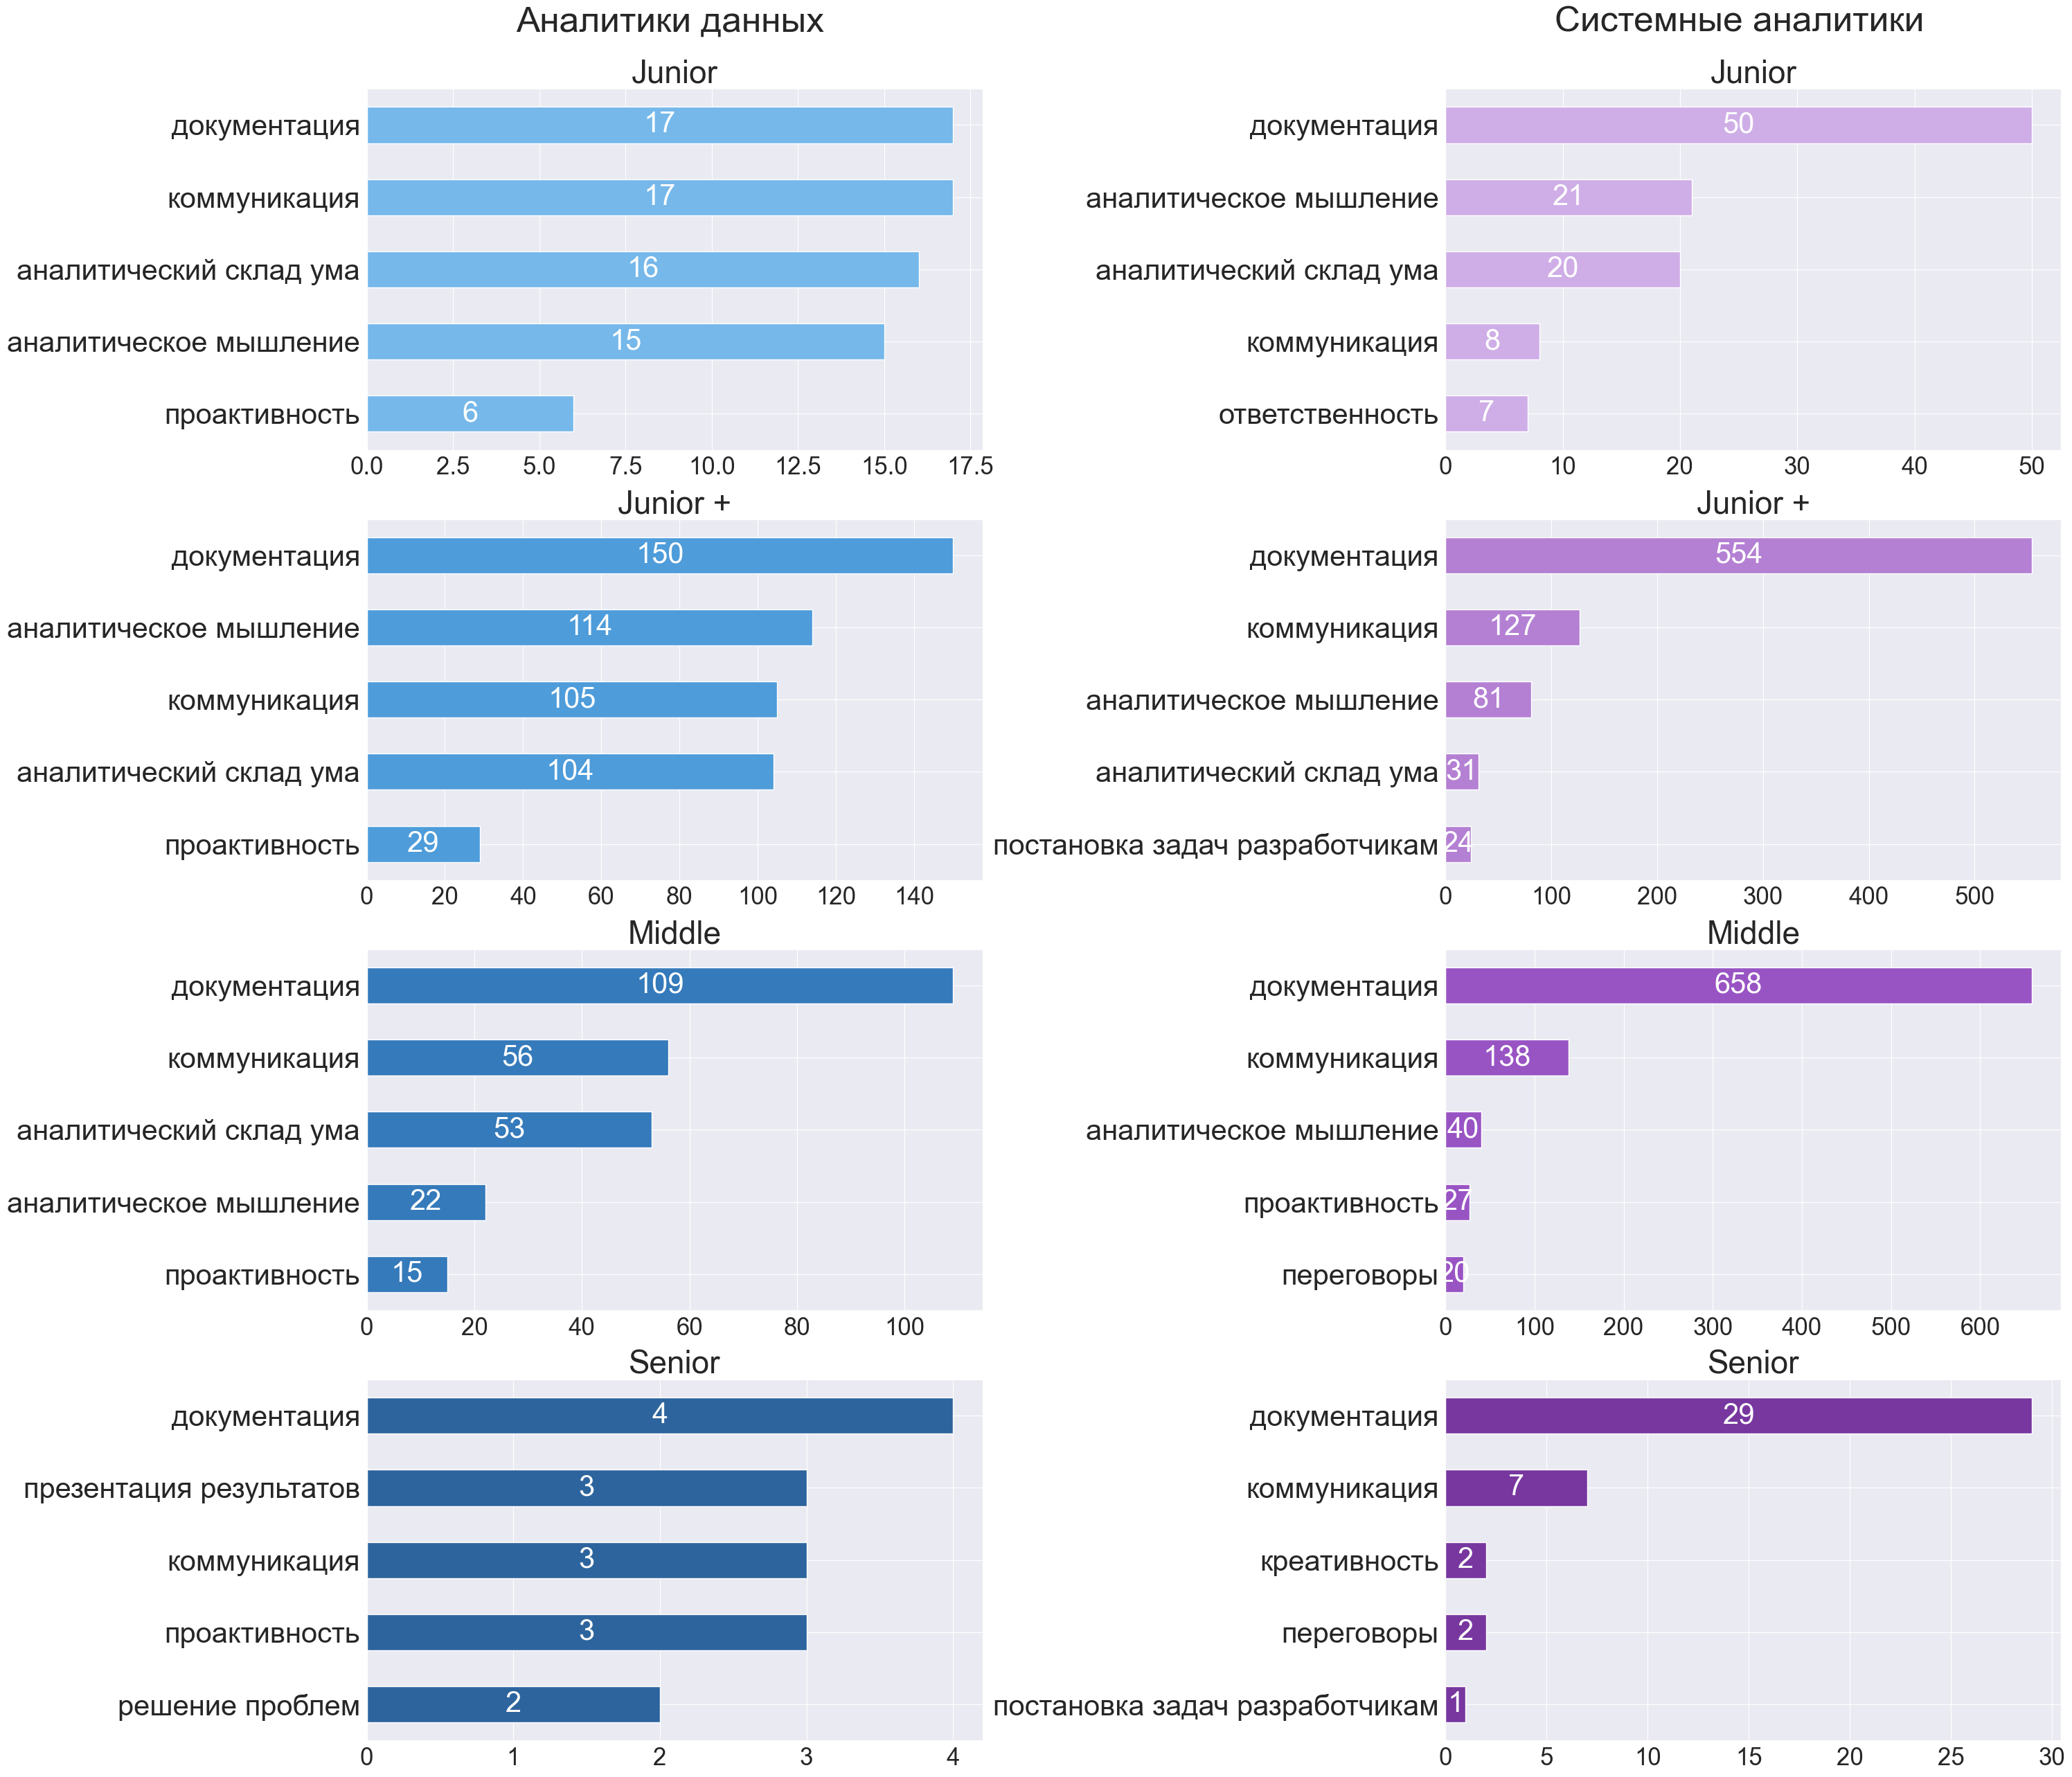

In [76]:
plot_pivot_table(top_soft_skills_experience_da, top_soft_skills_experience_sa, 'Аналитик данных')

Soft-skill - ДОКУМЕНТАЦИЯ! Одинакова актуальна для всех грейдов и должностей.

Для аналитиков данных необходимо быть коммуникабельным, проактивным, обладать аналитическим мышлением (и складом ума!), уметь презентовать результаты и решать проблемы (актуально для Senior).

Для системных аналитиков важно быть ответственным, коммуникабельным, креативным, уметь вести переговоры и ставить задачи разработчикам, обладать аналитическим складом ума.

## Вывод

Представим результаты исследовательского анализа вакансий на должности системных аналитиков и аналитиков данных сайта HH.ru.

В ходе предобработки данных были выявлены колонки с наибольшим количеством пустых ячеек. Были обработаны неявные дубликаты ключевых навыков, а также на основе данной колонки заполнены все пропуски в soft-skills и hard-skills. В процессе изучения уникальных навыков было отмечено, что hard-skills во много раз больше содержит уникальных навыков по сравнению с soft-skills. Были выделены месяцы размещения объявлений, дни недели и время. Заполнены зарплатные диапазоны для вакансий, содержащих только пороговое значение заработной платы.

Вакансии для аналитиков данных были собраны за период февраль - июль 2024 г., для системных аналитиков за июль и июнь. Большинство вакансий публикуется в начале неделе и далее наблюдается последовательный спад частоты. Как правило, вакансии выкладываются в рабочие часы с 8 утра до 8 вечера, пиковое значение приходится на утро.

Большинство вакансий для двух датафреймов рассчитано на грейд Junior+ и Middle. Для аналитиков превалирует доля вакансий Junior+ - 61% от всех вакансий должности, для системных аналитиков вакансии с грейдами Junior+ - 45% и Middle - 49%.

Типичное место работы аналитика данных: компания "СБЕР", город Москва, зарплата в диапазоне до 200 тыс. руб., график работы - полный рабочий день, тип занятости - полная.

Типичное место работы системного аналитика: компания "СБЕР", "T1", город Москва, зарплата в диапазоне от 100 до 300 тыс. руб., график работы - полный рабочий день, тип занятости - полная.

Уникальные навыки чаще складываются из hard-skills, это можно заметить по рейтингу всех уникальных навыков - большинство умений состовляют hard-skills. Также по сравнению рейтингов hard- и soft-skills можно отметить, что разнообразие hard-skills, а также встречаемость навыков достаточно высока для обоих должностей, в то время как soft-skills (за исключением документации) встречаются гораздо реже в вакансиях по сравнению с hard-skills.

Стек hard-skills для аналитиков данных: sql, python, pandas, power bi, excel, а также работа с базами данных и большим объемом информации.

Стек hard-skills для системных аналитиков: sql, bpmn, confluence, uml-диаграммы, rest api, atlassian.

Наиболее часто запрос soft-skills составляет документация, аналитическое мышление, проактивность, креативность и навык вести переговоры.


### Рекомендации для начинающих специалистов

1. Не распыляться на все hard-skills и не пытаться учить как можно больше инструментов анализа данных. Как уже было отмечено, основной стек технологий состоит из определенного набора навыков, которые будут одинаково актуальны с ростом грейда. Лучше качественнее подойти к изучению базы и уже после дополнять навыки другими инструментами, которые требует желаемая компания.
2. Не стоит забывать про soft-skills, несмотря на меньшую встречаемость, многие работодатели желают видеть кандидата обладающего навыками документации, способного выстроить коммуникацию как с коллегами, так и с заказчиками, умеющего проанализировать текущую ситуацию и представить результаты по ней.
3. Стоит ориентироваться на полный рабочий день и полную занятость.
4. Несмотря на всеобщие ожидания высоких зарплат в сфере IT, не стоит ожидать от первого рабочего опыта зарплату больше 100 тыс. руб. Большие зарплаты абсолютно точно имеются, но до них нужно "дорасти" до соответствующего грейда.
5. Вакансий на рынке труда действительно много, работа разнообразна и не монотонна, не стоит беспокоиться, что работы "не хватит".

________

### Приложение

Сводные таблицы для грейдов, которые формируют типичное место работы аналитика данных и системного аналитика:

Сводные таблицы с работодателями:

In [77]:
print('Аналитик данных')
display(employer_da)
print('Системный аналитик')
employer_sa

Аналитик данных


Грейд                                    Junior                      \
Топ-работодателей                  Работодатели Количество вакансий   
0                                          СБЕР                  13   
1                        МАГНИТ, Розничная сеть                   7   
2                  Согласие, страховая компания                   4   
3                                DNS Технологии                   4   
4                                         ANCOR                   3   

Грейд                    Junior +                           Middle  \
Топ-работодателей    Работодатели Количество вакансий Работодатели   
0                            СБЕР                 159         СБЕР   
1                  Банк ВТБ (ПАО)                  24  WILDBERRIES   
2                            Ozon                  17           Т1   
3                     WILDBERRIES                  16         Ozon   
4                             МТС                  15       Яндекс   

Грейд                                              Senior                      
Топ-работодателей Количество вакансий        Работодатели Количество вакансий  
0                                  71        Леруа Мерлен                   4  
1                                  26    Reinvent Baltics                   2  
2                                  21       CloudPayments                   1  
3                                  15         Секонд Сайт                   1  
4                                  14  Aramco Innovations                   1

Системный аналитик


Грейд                                 Junior                      \
Топ-работодателей               Работодатели Количество вакансий   
0                                      Aston                  16   
1                            Компания Апогей                   8   
2                  TWIGA Communication Group                   5   
3                                     Дунайс                   4   
4                                   Ред Софт                   3   

Грейд                           Junior +                           Middle  \
Топ-работодателей           Работодатели Количество вакансий Работодатели   
0                                   СБЕР                  42           Т1   
1                                  Aston                  25         СБЕР   
2                  Совкомбанк Технологии                  22        Aston   
3                                     Т1                  17          ПСБ   
4                        Красное & Белое                  16       Т-Банк   

Грейд                                       Senior                      
Топ-работодателей Количество вакансий Работодатели Количество вакансий  
0                                  57           Т1                   3  
1                                  51       Яндекс                   2  
2                                  23   Mediascope                   2  
3                                  21  БФТ-Холдинг                   2  
4                                  19      ТестОпс                   2

Сводные таблицы по зарплатам:

In [78]:
print('Аналитик данных')
display(salary_da)
print('Системный аналитик')
salary_sa

Аналитик данных


Грейд                                     Junior                      \
Распределние зарплаты                   Зарплата Количество вакансий   
0                               Меньше 100 тысяч                58.0   
1                      От 100 тысяч до 200 тысяч                 8.0   
2                           Вакансии отсутствуют                 0.0   
3                           Вакансии отсутствуют                 0.0   

Грейд                                   Junior +                      \
Распределние зарплаты                   Зарплата Количество вакансий   
0                      От 100 тысяч до 200 тысяч                 123   
1                               Меньше 100 тысяч                 101   
2                      От 200 тысяч до 300 тысяч                  28   
3                               Больше 300 тысяч                   3   

Грейд                                     Middle                      \
Распределние зарплаты                   Зарплата Количество вакансий   
0                      От 100 тысяч до 200 тысяч                  38   
1                               Больше 300 тысяч                  29   
2                      От 200 тысяч до 300 тысяч                  22   
3                               Меньше 100 тысяч                   9   

Грейд                                     Senior                      
Распределние зарплаты                   Зарплата Количество вакансий  
0                      От 200 тысяч до 300 тысяч                 3.0  
1                           Вакансии отсутствуют                 0.0  
2                           Вакансии отсутствуют                 0.0  
3                           Вакансии отсутствуют                 0.0

Системный аналитик


Грейд                                     Junior                      \
Распределние зарплаты                   Зарплата Количество вакансий   
0                               Меньше 100 тысяч                42.0   
1                      От 100 тысяч до 200 тысяч                 5.0   
2                               Больше 300 тысяч                 3.0   
3                           Вакансии отсутствуют                 0.0   

Грейд                                   Junior +                      \
Распределние зарплаты                   Зарплата Количество вакансий   
0                      От 100 тысяч до 200 тысяч                  99   
1                      От 200 тысяч до 300 тысяч                  52   
2                               Меньше 100 тысяч                  33   
3                               Больше 300 тысяч                   8   

Грейд                                     Middle                      \
Распределние зарплаты                   Зарплата Количество вакансий   
0                      От 200 тысяч до 300 тысяч                75.0   
1                               Больше 300 тысяч                74.0   
2                      От 100 тысяч до 200 тысяч                35.0   
3                           Вакансии отсутствуют                 0.0   

Грейд                                     Senior                      
Распределние зарплаты                   Зарплата Количество вакансий  
0                               Больше 300 тысяч                 6.0  
1                      От 200 тысяч до 300 тысяч                 3.0  
2                      От 100 тысяч до 200 тысяч                 1.0  
3                           Вакансии отсутствуют                 0.0